# LECTURE: FINANCIAL DATA ANALYSIS WITH PYTHON - Porflolios

**Lecture Workflow:**
1.  **Part 1 (Foundations):** A detailed lecture on Time Series Analysis concepts.
2.  **Part 2:** Apply a Train/Test workflow. Train sequential optimization models (n-assets, k-assets) on historical data, then objectively test them on future data.
3.  **Part 3 & 4:** Summary and References.

## PART 1: FOUNDATIONS OF TIME SERIES ANALYSIS

### 1.1: Setup and Global Imports

We will install and import all necessary libraries for the entire lecture here.

In [1]:
# --- Install Libraries ---
# Run once if you don't have them
#!pip install yfinance  numpy pandas matplotlib seaborn PyPortfolioOpt
#%pip install ecos scs clarabel cvxpy
# --- Imports for Data Analysis (Part 1 & 2) ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy # To copy objects
#%pip install riskfolio-lib
import riskfolio as rp
from pypfopt import CLA
from scipy.stats import skew, kurtosis
from itertools import product


# --- Imports for Portfolio Optimization (Part 2) ---
import itertools # To create combinations
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting 

# --- Global Settings ---
sns.set_theme(style="darkgrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

print("All libraries imported and settings configured.")

All libraries imported and settings configured.


### 1.2: Load Data for Part 1 (Introductory Data)

To learn the foundational concepts, we will load a large dataset (5 years) as an example.

In [2]:
intro_tickers = ["AAPL", "TSLA", "JPM", "NVDA", "SPY"]
years_of_data = 5 # Load 5 years to have enough data for examples

# Load data
intro_end_date = pd.Timestamp.today()
intro_start_date = intro_end_date - pd.DateOffset(years=years_of_data)

print(f"Loading data for {len(intro_tickers)} tickers (For Part 1 introduction only)")

try:
    intro_raw_data = yf.download(intro_tickers, start=intro_start_date, end=intro_end_date)['Close']
    intro_raw_data = intro_raw_data.ffill().dropna() 
    print("Introductory data loaded successfully.")
    print(intro_raw_data.tail())
except Exception as e:
    print(f"ERROR: {e}")

Loading data for 5 tickers (For Part 1 introduction only)


C:\Users\Admin\AppData\Local\Temp\ipykernel_18384\4051970135.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  intro_raw_data = yf.download(intro_tickers, start=intro_start_date, end=intro_end_date)['Close']
[*********************100%***********************]  5 of 5 completed

Introductory data loaded successfully.
Ticker            AAPL         JPM        NVDA         SPY        TSLA
Date                                                                  
2025-11-26  277.549988  307.640015  180.259995  679.679993  426.579987
2025-11-28  278.850006  313.079987  177.000000  683.390015  430.170013
2025-12-01  283.100006  308.920013  179.919998  680.270020  430.140015
2025-12-02  286.190002  307.880005  181.460007  681.530029  429.239990
2025-12-03  284.149994  312.130005  179.589996  683.890015  446.739990


### 1.3. Time Series

- **Concept:** A **time series** is a sequence of data points indexed in time order. Its most critical characteristic is **time dependence**; the order of the data is paramount.
- **Tool:** In `pandas`, this is represented by a `DatetimeIndex`. This special index allows for intelligent access, slicing, and processing based on dates/months/years.
- **Code:**

In [3]:
print(f"Index Type: {type(intro_raw_data.index)}")

# Benefit of DatetimeIndex: Slicing
print("\nData from 2023:")
# We can slice using a 'YYYY-MM-DD' string or just 'YYYY'
print(intro_raw_data.loc['2023'].head())

Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

Data from 2023:
Ticker            AAPL         JPM       NVDA         SPY        TSLA
Date                                                                 
2023-01-03  123.211182  125.492203  14.301481  367.150757  108.099998
2023-01-04  124.482048  126.662468  14.735069  369.985229  113.639999
2023-01-05  123.161942  126.634399  14.251526  365.762512  110.339996
2023-01-06  127.693565  129.057587  14.844966  374.150146  113.059998
2023-01-09  128.215714  128.524307  15.613239  373.938080  119.769997


### 1.4. Timezones

- **Concept:** Time data can be 'naive' (unaware of timezones) or 'aware' (has timezone information). Financial data must always be handled carefully regarding timezones (e.g., NYSE opening time vs. London time).
- **Tools:** 
  - `tz_localize(timezone_name)`: Assigns a timezone to naive data. Used once.
  - `tz_convert(timezone_name)`: Converts aware data from one timezone to another.
- **Code:**

In [4]:
print(f"Original Timezone Info: {intro_raw_data.index.tz}")

try:
    # 1. Localize (Assign the original market timezone - New York)
    data_localized = intro_raw_data.tz_localize('America/New_York', ambiguous='infer')
    print(f"Timezone after localization: {data_localized.index.tz}")
    print("New York Time:")
    print(data_localized.head(1))

    # 2. Convert (To Vietnam time)
    data_hcm = data_localized.tz_convert('Asia/Ho_Chi_Minh')
    print(f"\nTimezone after conversion: {data_hcm.index.tz}")
    print("Vietnam Time (corresponding):")
    print(data_hcm.head(1))
except TypeError as e:
    print(f"Error: {e}. Data may already be timezone-aware.")

Original Timezone Info: None
Timezone after localization: America/New_York
New York Time:
Ticker                           AAPL         JPM       NVDA         SPY        TSLA
Date                                                                                
2020-12-07 00:00:00-05:00  120.464706  107.044006  13.569349  344.088135  213.919998

Timezone after conversion: Asia/Ho_Chi_Minh
Vietnam Time (corresponding):
Ticker                           AAPL         JPM       NVDA         SPY        TSLA
Date                                                                                
2020-12-07 12:00:00+07:00  120.464706  107.044006  13.569349  344.088135  213.919998


- **Observation:** 00:00 (midnight) New York time (UTC-4 or -5) corresponds to 11:00 (or 12:00) AM Vietnam time (UTC+7). Timezone handling is critical when working with high-frequency (intraday) data.

### 1.5. Resampling (Changing Frequency)

- **Concept:** Resampling is the process of changing the frequency of data (e.g., from daily to monthly, or daily to hourly). There are 2 types:
  1. **Downsampling:** Aggregating data from a high frequency to a low frequency (e.g., daily -> monthly). Requires an **aggregation function**.
  2. **Upsampling:** Converting data from a low frequency to a high frequency (e.g., daily -> hourly). Requires a **filling method**.
- **Tools:**
  - `data.resample(new_frequency)`: Creates a Resampler object.
  - **Aggregation (Downsampling):** `.mean()`, `.last()`, `.sum()`, `.ohlc()`.
  - **Filling (Upsampling):** `.ffill()` (forward-fill), `.bfill()` (back-fill), `.asfreq()` (creates `NaN`).
- **Code (Downsampling):**

In [5]:
# Use 'AAPL' as an example
aapl = intro_raw_data[['AAPL']].copy().dropna()

# Downsampling: Daily -> Monthly ('M')
# We take the last value of each month
aapl_monthly = aapl.resample('M').last()
print("--- Monthly Data (Last value) ---")
print(aapl_monthly.head())

# Downsampling: Create weekly OHLC (Open-High-Low-Close) ('W')
aapl_ohlc_weekly = aapl['AAPL'].resample('W').ohlc()
print("\n--- Weekly OHLC Data --- (Open, High, Low, Close)")
print(aapl_ohlc_weekly.head())

--- Monthly Data (Last value) ---
Ticker            AAPL
Date                  
2020-12-31  129.167389
2021-01-31  128.456757
2021-02-28  118.217201
2021-03-31  119.084885
2021-04-30  128.161270

--- Weekly OHLC Data --- (Open, High, Low, Close)
                  open        high         low       close
Date                                                      
2020-12-13  120.464706  121.077995  118.547020  119.160309
2020-12-20  118.547020  125.283302  118.547020  123.297478
2020-12-27  124.825760  128.466522  124.825760  128.466522
2021-01-03  133.061203  133.061203  129.167389  129.167389
2021-01-10  125.974464  128.544388  123.239052  128.544388


C:\Users\Admin\AppData\Local\Temp\ipykernel_18384\3466493821.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aapl_monthly = aapl.resample('M').last()


- **Visualization (Downsampling):**

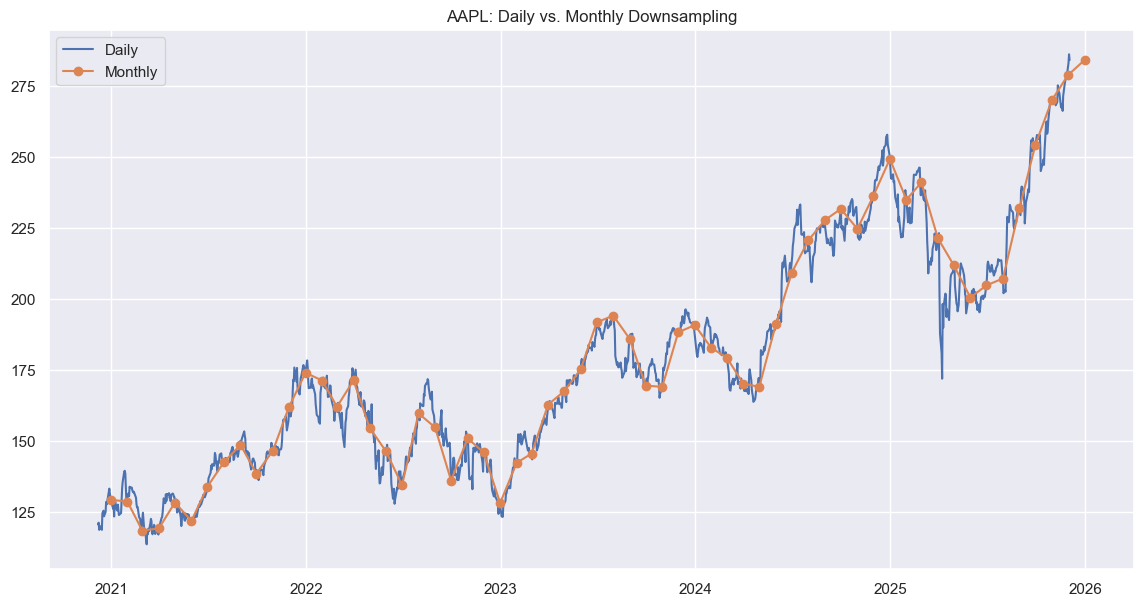

In [6]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(aapl['AAPL'], label = "Daily")
ax.plot(aapl_monthly, label = 'Monthly', marker = 'o')


plt.title('AAPL: Daily vs. Monthly Downsampling')
plt.legend()
plt.show()

- **Observation (Downsampling):** Downsampling is useful for seeing long-term trends and removing daily noise.

### 1.6. Returns

- **Concept:** Returns measure the percentage change in price. This is the most important unit in finance, more so than absolute price.
- **Formula (Simple Return):**
  $R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$
- **Tool:** `series.pct_change()`
- **Formula (Log Return):** (Useful for its additive properties)
  $r_t = \ln(\frac{P_t}{P_{t-1}}) = \ln(P_t) - \ln(P_{t-1})$
- **Tool:** `np.log(series / series.shift(1))`
- **Code (Simple Return):**

In [7]:
# Use SPY as an example
spy = intro_raw_data[['SPY']].copy().dropna()

# 1. Calculate Simple Return
spy['Returns_Simple'] = spy['SPY'].pct_change()

# 2. Calculate Log Return
spy['Returns_Log'] = np.log(spy['SPY'] / spy['SPY'].shift(1))

# Drop the first NA row (from .pct_change() and .shift())
spy = spy.dropna()

print(spy.head())

Ticker             SPY  Returns_Simple  Returns_Log
Date                                               
2020-12-08  345.094971        0.002926     0.002922
2020-12-09  341.999908       -0.008969    -0.009009
2020-12-10  341.888092       -0.000327    -0.000327
2020-12-11  341.487122       -0.001173    -0.001174
2020-12-14  339.958191       -0.004477    -0.004487


- **Visualization (Returns):**

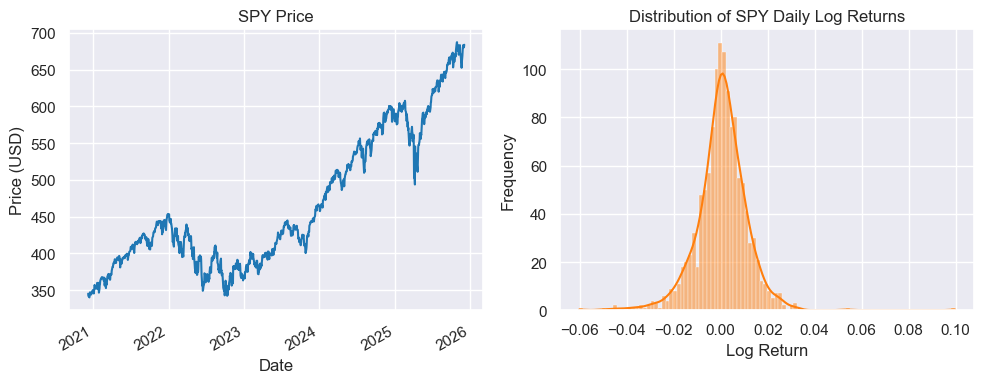

In [8]:
# Price chart and histogram of SPY log returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Price plot
spy['SPY'].plot(ax=ax1, title='SPY Price', color='tab:blue')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)

# Histogram of log returns
sns.histplot(spy['Returns_Log'].dropna(), bins=100, kde=True, ax=ax2, color='tab:orange')
ax2.set_title('Distribution of SPY Daily Log Returns')
ax2.set_xlabel('Log Return')
ax2.set_ylabel('Frequency')
ax2.grid(True)

plt.tight_layout()
plt.show()

- **Observation:** Plot 1 shows the price is trended (non-stationary). Plot 2 shows the returns are **stationary** (reverting around 0) and have fat tails - characteristic of financial data.

### 1.7. Rolling Statistics

- **Concept:** Calculating a statistic (like mean, std dev) on a fixed-size **'window'** of data, then sliding that window over the entire time series.
- **Tool:** `series.rolling(window=k)`: Creates a Rolling object.
- **Applied Functions:** `.mean()`, `.std()`, `.sum()`, `.corr()`.

---

#### 1.7.1. Simple Moving Average (SMA)

- **Concept:** The average of the last $k$ data points.
- **Use:** Smooths short-term price data to highlight long-term trends.
- **Formula:** $SMA_t(k) = \frac{1}{k} \sum_{i=0}^{k-1} P_{t-i}$
- **Tool:** `series.rolling(window=k).mean()`
- **Code:**

Visualizing SPY 50 and 200 SMA (Last 2 years):


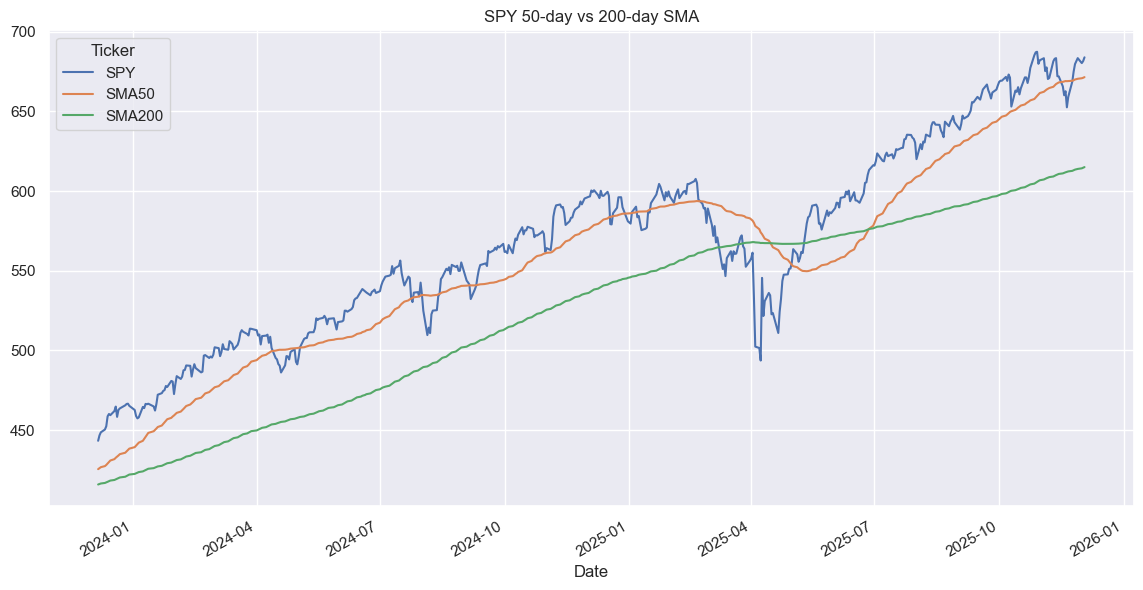

In [9]:
# Calculate 50-day and 200-day SMA for SPY
spy['SMA50'] = spy['SPY'].rolling(window=50).mean()
spy['SMA200'] = spy['SPY'].rolling(window=200).mean()

# Visualize SMA (only last 2 years for clarity)
print("Visualizing SPY 50 and 200 SMA (Last 2 years):")
spy.iloc[-500:][['SPY', 'SMA50', 'SMA200']].plot(title='SPY 50-day vs 200-day SMA', figsize=(14, 7))
plt.show()

- **Observation:** When the short SMA (50) crosses above the long SMA (200), it signals an uptrend (Golden Cross). When it crosses below, it signals a downtrend (Death Cross).

#### 1.7.2. Rolling Volatility

- **Concept:** A measure of risk, showing the dispersion of returns. We calculate it as the **standard deviation** of returns in a rolling window.
- **Formula (Sample Std Dev):** $\sigma_t(k) = \sqrt{\frac{1}{k-1} \sum_{i=0}^{k-1} (r_{t-i} - \bar{r}_t)^2}$
- **Annualizing:** $\sigma_{annual} = \sigma_{daily} \times \sqrt{252}$
- **Tool:** `series_returns.rolling(window=k).std() * np.sqrt(252)`
- **Code:**

Visualizing SPY 21-day Rolling Volatility (Annualized):


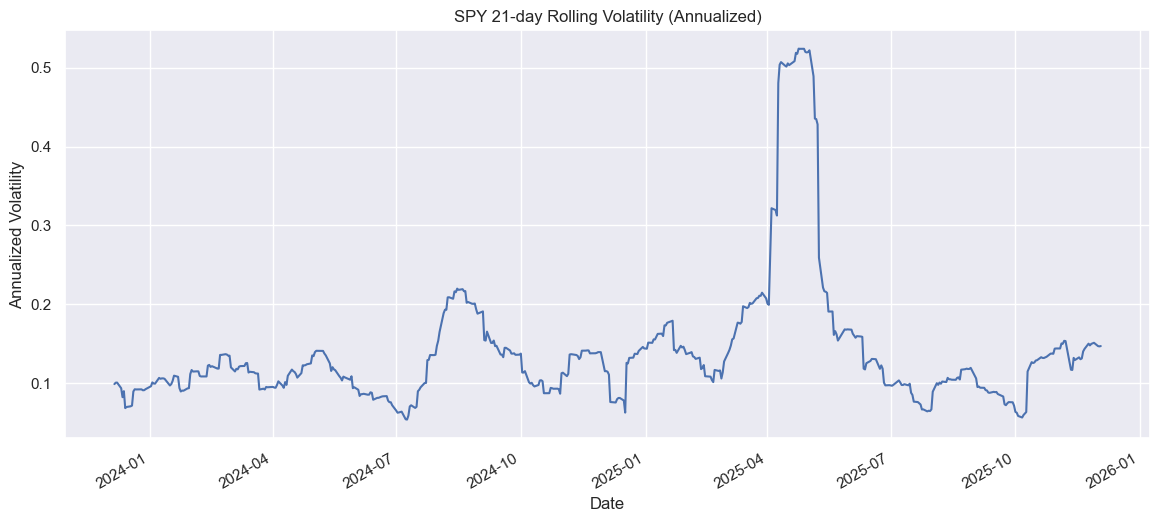

In [10]:
# Calculate 21-day rolling std dev of Log Returns
# (21 trading days ~ 1 month)
# Multiply by sqrt(252) (trading days in a year) to *annualize* it
spy['Volatility'] = spy['Returns_Log'].rolling(window=21).std() * np.sqrt(252)

print("Visualizing SPY 21-day Rolling Volatility (Annualized):")
spy['Volatility'].iloc[-500:].plot(title='SPY 21-day Rolling Volatility (Annualized)', figsize=(14, 6))
plt.ylabel('Annualized Volatility')
plt.show()

- **Observation:** The plot shows periods of calm (low volatility) and periods of storm (high volatility, e.g., the 2020 COVID-19 crisis).

#### 1.7.3. Rolling Correlation

- **Concept:** Measures how two assets move together (from -1 to 1) and how this relationship changes over time. This is the core concept of **Diversification**.
- **Tool:** `series1.rolling(window=k).corr(series2)`
- **Code:**

Visualizing 60-day Rolling Correlation (AAPL vs SPY):


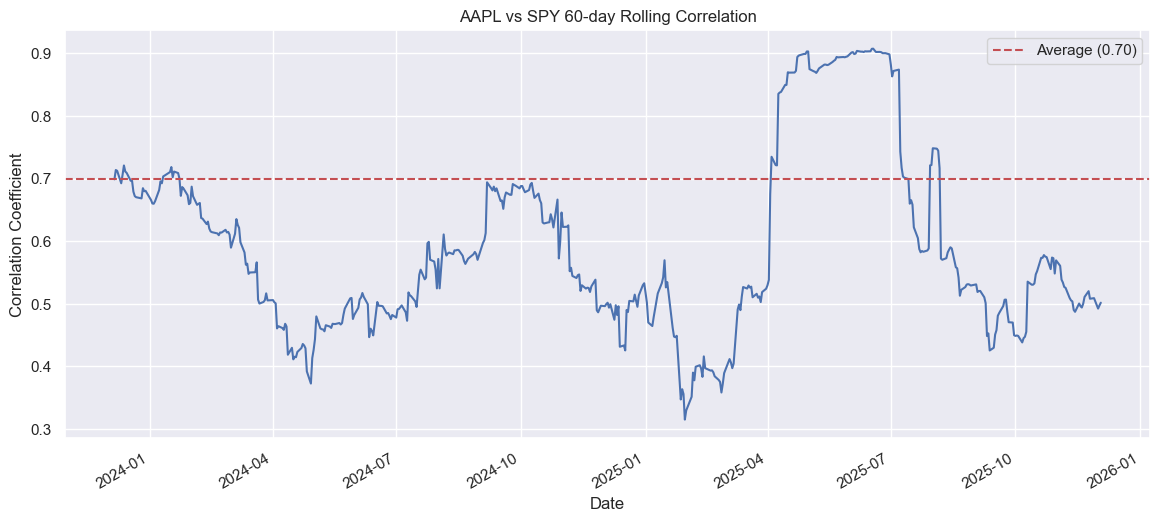

In [11]:
# Get log returns for AAPL and SPY (the market)
market_returns = np.log(intro_raw_data['SPY'] / intro_raw_data['SPY'].shift(1))
stock_returns = np.log(intro_raw_data['AAPL'] / intro_raw_data['AAPL'].shift(1))

# Calculate 60-day rolling correlation (~ 3 months)
rolling_corr = stock_returns.rolling(window=60).corr(market_returns)
rolling_corr = rolling_corr.dropna()

print("Visualizing 60-day Rolling Correlation (AAPL vs SPY):")
rolling_corr.iloc[-500:].plot(title='AAPL vs SPY 60-day Rolling Correlation', figsize=(14, 6))
plt.ylabel('Correlation Coefficient')
plt.axhline(rolling_corr.mean(), color='r', linestyle='--', label=f'Average ({rolling_corr.mean():.2f})')
plt.legend()
plt.show()

- **Observation:** The correlation between AAPL and SPY is not fixed. In Part 2, we will optimize portfolios based on these correlations.

## PART 2: PORTFOLIO OPTIMIZATION

### 2.1. Load Data and Train-Test Split

End of the foundational section. Now, we load data for our Train/Test model.
- **Total Period:** 2 years + 1 month (Example: 1/1/2023 - 1/31/2025)
- **Train Set:** 1/1/2023 - 12/31/2024 (2 years for Training)
- **Test Set:** 1/1/2025 - 1/31/2025 (1 month for Testing)

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA']
risk_free_rate = 0.02
n= len(tickers)

start_date = "2020-01-01"
end_date   = "2025-11-30"

print(f"--- PREPARING DATA FOR PART 2 ---")
print(f"Reloading data for {n} tickers: {tickers}")
print(f"Total period: {start_date} to {end_date}")

data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)['Close']

data = data.ffill().dropna()

print(f"Total days downloaded: {len(data)}")

# -------------------------------------------
# 3. SPLIT INTO 60% / 20% / 20%
# -------------------------------------------
total_len = len(data)
train_end   = int(total_len * 0.60)
valid_end   = int(total_len * 0.80)

train_data = data.iloc[:train_end]
valid_data = data.iloc[train_end:valid_end]
test_data  = data.iloc[valid_end:]

# -------------------------------------------
# 4. SUMMARY
# -------------------------------------------
print("\n=== DATASET SPLIT SUMMARY ===")

print(f"Total period: {data.index.min().date()} → {data.index.max().date()}")
print(f"Total rows  : {total_len}\n")

print(f"TRAIN (60%): {train_data.index.min().date()} → {train_data.index.max().date()} | {len(train_data)} rows")
print(f"VALID (20%): {valid_data.index.min().date()} → {valid_data.index.max().date()} | {len(valid_data)} rows")
print(f"TEST  (20%): {test_data.index.min().date()}  → {test_data.index.max().date()} | {len(test_data)} rows")

--- PREPARING DATA FOR PART 2 ---
Reloading data for 5 tickers: ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA']
Total period: 2020-01-01 to 2025-11-30
Total days downloaded: 1486

=== DATASET SPLIT SUMMARY ===
Total period: 2020-01-02 → 2025-11-28
Total rows  : 1486

TRAIN (60%): 2020-01-02 → 2023-07-18 | 891 rows
VALID (20%): 2023-07-19 → 2024-09-20 | 297 rows
TEST  (20%): 2024-09-23  → 2025-11-28 | 298 rows


In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'SPY', 'NVDA']
risk_free_rate = 0.02

csv_file = "data.csv"

print(f"--- PREPARING DATA FOR PART 2 ---")
print(f"Loading data from CSV for {len(tickers)} tickers: {tickers}")

data = pd.read_csv(csv_file, parse_dates=['Date'], index_col='Date')
data = data[tickers]
data = data.ffill().dropna()

print(f"Total days loaded: {len(data)}")

#SPLIT INTO 60% / 20% / 20%
total_len = len(data)
train_end = int(total_len * 0.60)
valid_end = int(total_len * 0.80)

train_data = data.iloc[:train_end]
valid_data = data.iloc[train_end:valid_end]
test_data  = data.iloc[valid_end:]

#  SUMMARY_
print("\n=== DATASET SPLIT SUMMARY ===")
print(f"Total period: {data.index.min().date()} → {data.index.max().date()}")
print(f"Total rows  : {total_len}\n")

print(f"TRAIN (60%): {train_data.index.min().date()} → {train_data.index.max().date()} | {len(train_data)} rows")
print(f"VALID (20%): {valid_data.index.min().date()} → {valid_data.index.max().date()} | {len(valid_data)} rows")
print(f"TEST  (20%): {test_data.index.min().date()}  → {test_data.index.max().date()} | {len(test_data)} rows")

In [28]:
# List of 5 tickers (Added NVDA as the 5th ticker for diversification)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'SPY', 'NVDA']
n = len(tickers)
risk_free_rate = 0.02 # Assumed risk-free rate (e.g., T-Bill)

# 1. Define time periods
# (Note: We use fixed dates to ensure the lecture is reproducible)
start_date = "2020-01-01"
end_date = "2025-11-30"
split_date = "2024-12-31" # Last day of the Train set

print(f"--- PREPARING DATA FOR PART 2 ---")
print(f"Reloading data for {n} tickers: {tickers}")
print(f"Total period: {start_date} to {end_date}")

# --- Download Price Data ---
data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,   # automatically adjusts for dividends & splits
    progress=False
)['Close']

# --- Validate Download ---
missing_tickers = set(tickers) - set(data.columns)
if missing_tickers:
    print(f"⚠️ Warning: Missing price data for {missing_tickers}")

# --- Clean & Prepare Data ---
# Forward-fill small gaps; remaining NaN rows removed
data = data.ffill().dropna()

# --- Train-Test Split ---
# Train Set: From start date up to and including the split date (2023-2024)
train_data = data.loc[:split_date]
# Test Set: Strictly after the split date (Nov 2025)
valid_data = data.loc[data.index > split_date]

print("\nData loaded and split successfully.")
print(f"Total data: {len(data)} days")
print(f"--- TRAIN SET ---")
print(f"Period: {train_data.index.min().date()} -> {train_data.index.max().date()}")
print(f"Shape:  {train_data.shape} (Rows, Columns)") # Verify we have 5 columns
    
print(f"--- TEST SET ---")
print(f"Period: {valid_data.index.min().date()} -> {valid_data.index.max().date()}")
print(f"Shape:  {valid_data.shape} (Rows, Columns)")


--- PREPARING DATA FOR PART 2 ---
Reloading data for 5 tickers: ['AAPL', 'MSFT', 'GOOGL', 'SPY', 'NVDA']
Total period: 2020-01-01 to 2025-11-30

Data loaded and split successfully.
Total data: 1486 days
--- TRAIN SET ---
Period: 2020-01-02 -> 2024-12-31
Shape:  (1258, 5) (Rows, Columns)
--- TEST SET ---
Period: 2025-01-02 -> 2025-11-28
Shape:  (228, 5) (Rows, Columns)


### 2.2: Calculate Expected Returns (mu) and Risk (S) *on Train Set*

This is the "Training" step. All base calculations (mu, S) are **ONLY** allowed on the `train_data`.

=== EXPECTED RETURNS & RISK (TRAIN SET) ===
--- EXPECTED RETURNS (mu) FROM TRAIN SET ---
Ticker
AAPL     0.316538
GOOGL    0.182649
MSFT     0.267986
NVDA     0.798490
TSLA     0.931530
dtype: float64

--- RISK MATRIX (S) FROM TRAIN SET ---
Ticker    AAPL   GOOGL    MSFT    NVDA    TSLA
Ticker                                        
AAPL    0.1224  0.0848  0.0934  0.1330  0.1270
GOOGL   0.0848  0.1175  0.0931  0.1270  0.1046
MSFT    0.0934  0.0931  0.1145  0.1395  0.1136
NVDA    0.1330  0.1270  0.1395  0.3149  0.2088
TSLA    0.1270  0.1046  0.1136  0.2088  0.4932


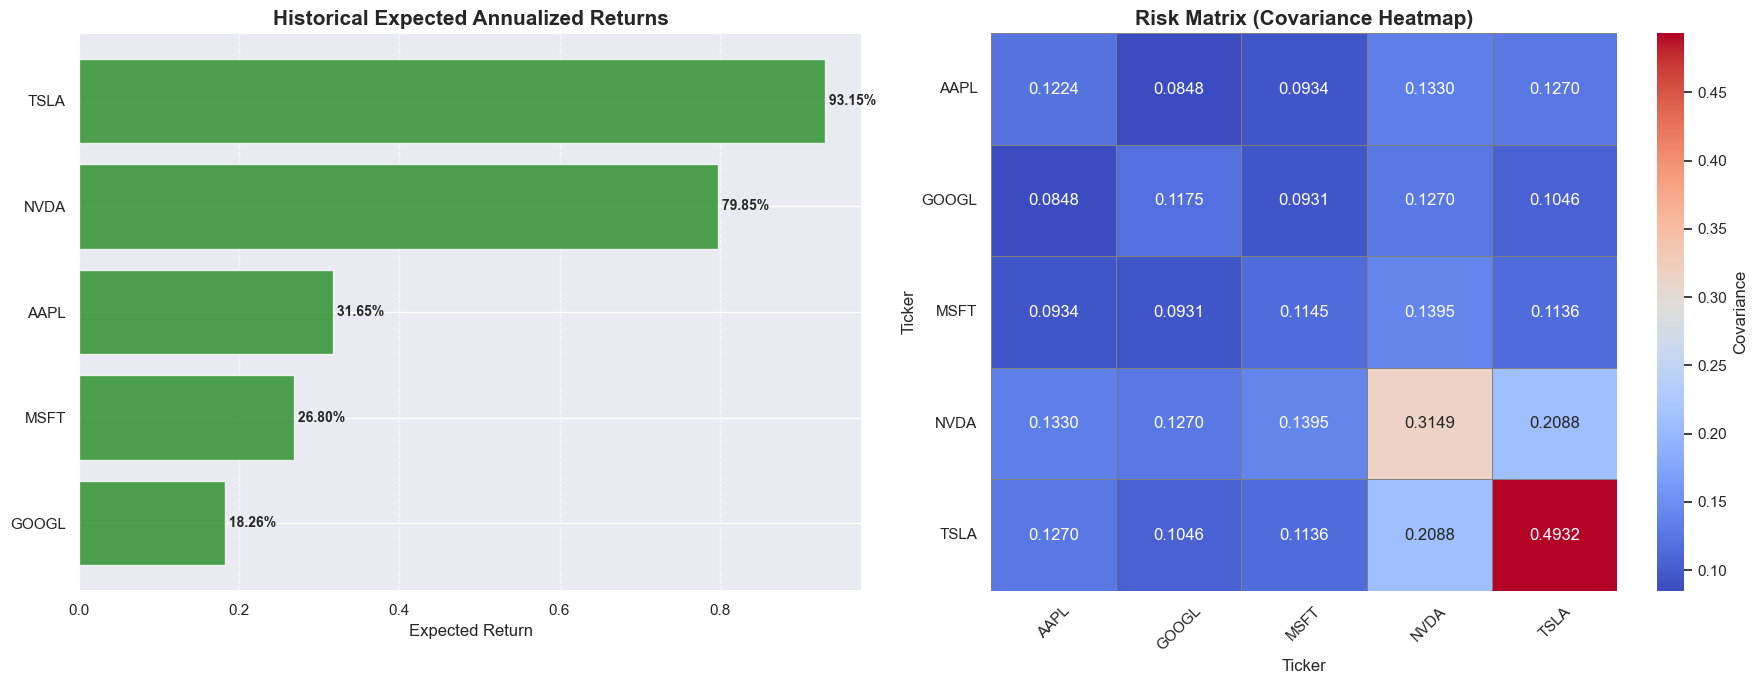

In [3]:
# --- MVO: Historical Expected Returns & Covariance ---
print("=== EXPECTED RETURNS & RISK (TRAIN SET) ===")
# 1. Calculate Expected Returns (mu) ONLY ON TRAIN SET
mu_train = expected_returns.mean_historical_return(train_data, frequency=252)

# 2. Calculate Covariance Matrix (S) ONLY ON TRAIN SET
S_train = risk_models.sample_cov(train_data, frequency=252)

print("--- EXPECTED RETURNS (mu) FROM TRAIN SET ---")
print(mu_train)
print("\n--- RISK MATRIX (S) FROM TRAIN SET ---")
print(S_train.round(4))

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 3.
mu_sorted = mu_train.sort_values(ascending=True)
colors = ['red' if x < 0 else 'forestgreen' for x in mu_sorted.values]

axes[0].barh(mu_sorted.index, mu_sorted.values, color=colors, alpha=0.8)
axes[0].set_title('Historical Expected Annualized Returns', fontsize=15, fontweight='bold')
axes[0].set_xlabel('Expected Return', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

for index, value in enumerate(mu_sorted.values):
    label_x_pos = value if value >= 0 else 0
    ha = 'left' if value >= 0 else 'right'
    axes[0].text(label_x_pos, index, f" {value:.2%}", va='center', ha=ha, fontsize=10, fontweight='bold')

#4
sns.heatmap(S_train, annot=True, fmt=".4f", cmap="coolwarm", 
            linewidths=0.5, linecolor='gray', ax=axes[1], cbar_kws={'label': 'Covariance'})

axes[1].set_title('Risk Matrix (Covariance Heatmap)', fontsize=15, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()


--- EVaR: Riskfolio computed ANNUALIZED mu ---


,0
AAPL,0.336251
GOOGL,0.226540
MSFT,0.294765
NVDA,0.743524
TSLA,0.905501



--- EVaR: Riskfolio computed ANNUALIZED covariance ---


,AAPL,GOOGL,MSFT,NVDA,TSLA
AAPL,0.1224,0.0848,0.0934,0.1330,0.1270
GOOGL,0.0848,0.1175,0.0931,0.1270,0.1046
MSFT,0.0934,0.0931,0.1145,0.1395,0.1136
NVDA,0.1330,0.1270,0.1395,0.3149,0.2088
TSLA,0.1270,0.1046,0.1136,0.2088,0.4932


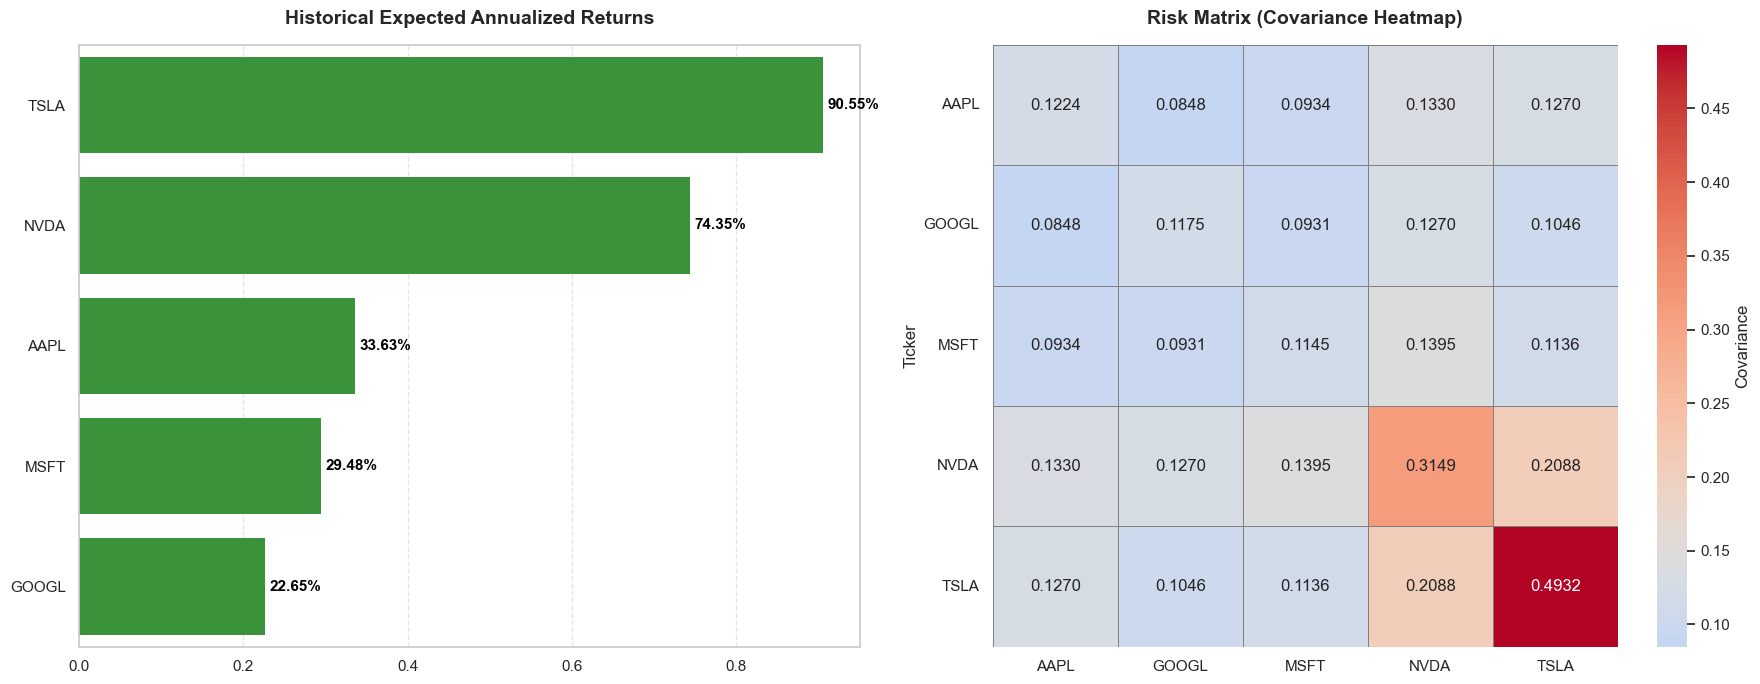

In [4]:
# --- EVaR: Prepare data for Riskfolio Portfolio ---
# Riskfolio expects returns in a DataFrame (dates x assets)
returns_train = train_data.pct_change().dropna()

# Initialize portfolio object for EVaR optimization
port_evar = rp.Portfolio(returns=returns_train)

# Let Riskfolio compute expected returns & covariance internally
method_mu = 'hist'    
method_cov = 'hist'   

port_evar.assets_stats(method_mu=method_mu, method_cov=method_cov)
annual_factor = 252
port_evar.mu = port_evar.mu * annual_factor
port_evar.cov = port_evar.cov * annual_factor

# Step 5: Check annualized mu and cov
print("\n--- EVaR: Riskfolio computed ANNUALIZED mu ---")
display(port_evar.mu.T)
print("\n--- EVaR: Riskfolio computed ANNUALIZED covariance ---")
display(port_evar.cov.round(4))

if isinstance(port_evar.mu, pd.DataFrame):
    mu_series = port_evar.mu.squeeze() 
else:
    mu_series = port_evar.mu

# DataFrame 
df_mu = pd.DataFrame({'Asset': mu_series.index, 'Return': mu_series.values})
df_mu_sorted = df_mu.sort_values(by='Return', ascending=False) 
cov_df = port_evar.cov

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# === HISTORICAL RETURNS  ===
ax1 = axes[0]
barplot = sns.barplot(data=df_mu_sorted,x='Return',y='Asset',color='#2ca02c', ax=ax1,edgecolor='none')

for i, p in enumerate(barplot.patches):
    width = p.get_width()
    
    ax1.text(
        width + (0.005 if width > 0 else -0.04), 
        p.get_y() + p.get_height()/2,
        f'{width:.2%}', 
        ha='left' if width > 0 else 'right', 
        va='center',
        fontweight='bold', color='black', fontsize=11
    )

ax1.set_title('Historical Expected Annualized Returns', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.grid(axis='x', linestyle='--', alpha=0.5)

# RISK MATRIX (HEATMAP) ===
ax2 = axes[1]
sns.heatmap(
    cov_df,
    annot=True,         
    fmt=".4f",          
    cmap='coolwarm',    
    linewidths=0.5,     
    linecolor='gray',
    cbar_kws={'label': 'Covariance'},
    ax=ax2,
    center=cov_df.values.mean() 
)

ax2.set_title('Risk Matrix (Covariance Heatmap)', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Ticker', fontsize=12)
ax2.tick_params(axis='x', rotation=0)
ax2.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()



#### Observation:
- Expected return:
- Risk matrix:

### 2.3: (Training) Optimize n-assets (Max Sharpe) on Train Set

Find the best portfolio (balancing Return/Risk) using *all* $n=5$ assets, based on past data.

--- Training: Optimizing n-Assets (Max Sharpe) - MVO ---
Static Weights found (n-MaxSharpe):
        Weight
NVDA   0.60871
TSLA   0.39129
AAPL   0.00000
MSFT   0.00000
GOOGL  0.00000

Performance (In-Sample, on Train Set):
Expected annual return: 85.1%
Annual volatility: 54.0%
Sharpe Ratio: 1.54

--- Training Optimize Max Sharpe - EVaR ---
Optimizing with Risk Measure='EVaR'...

--- OPTIMAL WEIGHTS ---
            weights
AAPL   7.495148e-10
GOOGL  6.033688e-10
MSFT   5.096688e-10
NVDA   4.521034e-01
TSLA   5.478966e-01
----------------------------------------
Performance (In-Sample) - EVaR:
Expected annual return: 83.2%
Annual EVaR risk:       179.8%
Sharpe Ratio (Return/EVaR): 0.463
----------------------------------------


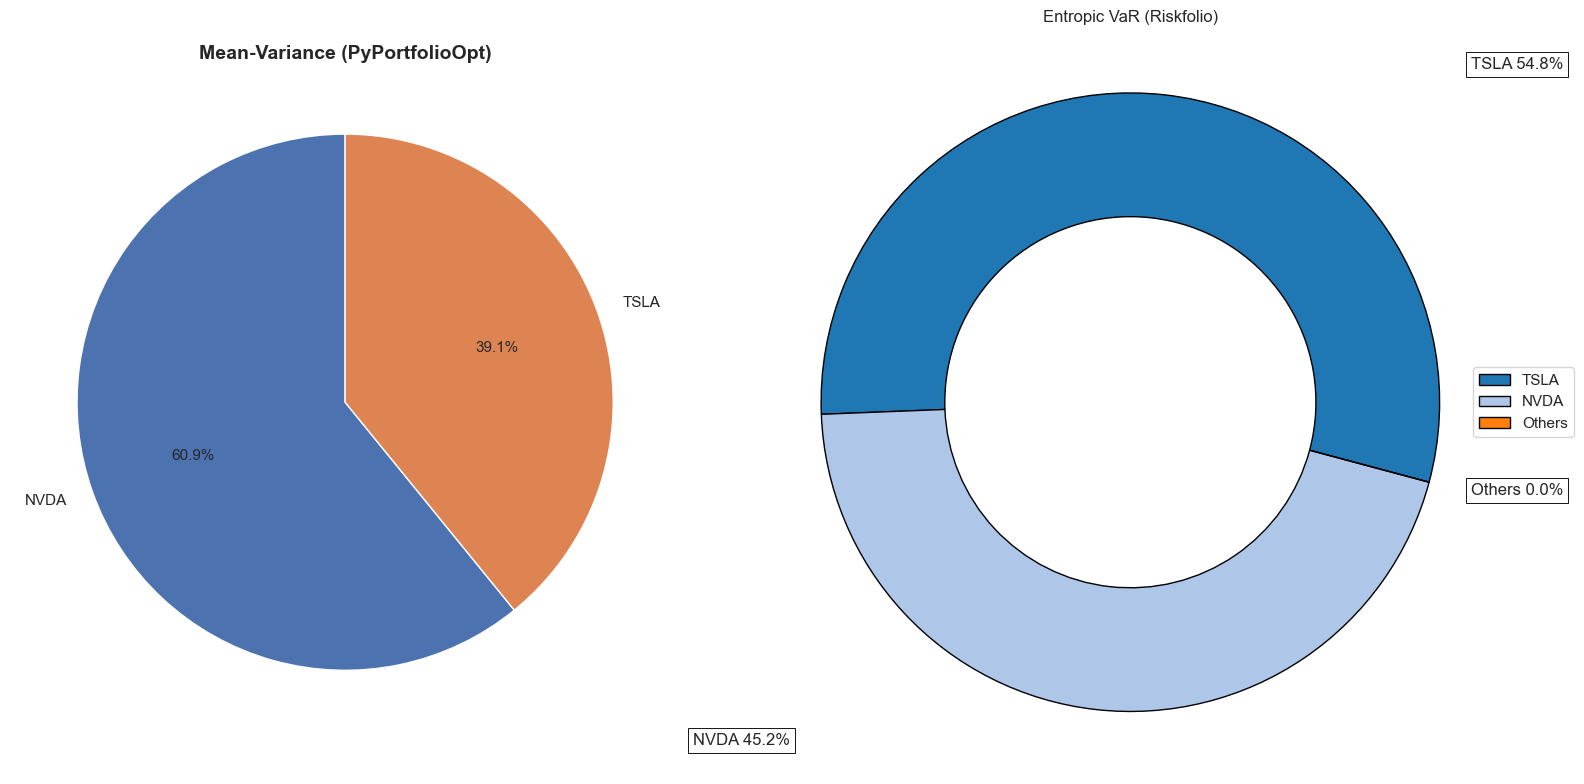

In [5]:
#1. Mean-Variance Optimization (MVO)
print("--- Training: Optimizing n-Assets (Max Sharpe) - MVO ---")
ef_sharpe = EfficientFrontier(mu_train, S_train, weight_bounds=(0, 1))

weights_sharpe = ef_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights_sharpe = ef_sharpe.clean_weights()

weights_sharpe_df = pd.DataFrame.from_dict(cleaned_weights_sharpe, orient='index', columns=['Weight'])
weights_sharpe_df = weights_sharpe_df.sort_values(by='Weight', ascending=False)

print("Static Weights found (n-MaxSharpe):")
print(weights_sharpe_df)
print("\nPerformance (In-Sample, on Train Set):")
ef_sharpe.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

#2. Max Sharpe Optimization with EVaR
#%pip install scs
print(f"\n--- Training Optimize Max Sharpe - EVaR ---")

port_sharpe = rp.Portfolio(returns=returns_train)
port_sharpe.assets_stats(method_mu='hist', method_cov='hist')

print("Optimizing with Risk Measure='EVaR'...")
w_evar = port_sharpe.optimization(model='Classic', rm='EVaR', obj='Sharpe', 
                                  rf=0, l=0, hist=True)

print("\n--- OPTIMAL WEIGHTS ---")
print(w_evar)
#Calculate Performance (Manual Calculation)
w_arr_s = w_evar.values.flatten()
mu_arr_s = port_sharpe.mu.values.flatten()
ann_factor = 252

# Annual Return
ret_annual_s = np.sum(w_arr_s * mu_arr_s) * ann_factor

# EVaR Risk
port_ret_s = returns_train.values @ w_arr_s
evar_daily_s = rp.RiskFunctions.EVaR_Hist(port_ret_s, alpha=0.05)[0]
evar_annual_s = evar_daily_s * np.sqrt(ann_factor)

# Sharpe based on EVaR
sharpe_ratio = ret_annual_s / evar_annual_s

print("-" * 40)
print("Performance (In-Sample) - EVaR:")
print(f"Expected annual return: {ret_annual_s:.1%}")
print(f"Annual EVaR risk:       {evar_annual_s:.1%}")
print(f"Sharpe Ratio (Return/EVaR): {sharpe_ratio:.3f}")
print("-" * 40)
#3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
plot_data_1 = weights_sharpe_df[weights_sharpe_df['Weight'] > 0]

plot_data_1.plot(
    kind="pie",
    y='Weight',
    autopct='%1.1f%%',
    startangle=90,
    legend=False,       
    ax=axes[0],         
    fontsize=11
)
axes[0].set_ylabel("") 
axes[0].set_title("Mean-Variance (PyPortfolioOpt)", fontsize=14, fontweight='bold')

rp.plot_pie(
    w=w_evar,
    title='Entropic VaR (Riskfolio)',
    height=6,
    width=10,
    cmap="tab20",
    ax=axes[1]          
)

plt.tight_layout()
plt.show()

#### Observation:

### 2.4: (Training) Optimize n-assets (Min Volatility) on Train Set

Find the safest (lowest risk) portfolio using *all* $n=4$ assets, based on past data.

--- Training: Optimizing n-Assets (Min Volatility) on Train Set ---
Static Weights found (n-MinVol):
AAPL     0.32482
GOOGL    0.37652
MSFT     0.29865
NVDA     0.00000
TSLA     0.00000
dtype: float64

Performance (In-Sample, on Train Set):
Expected annual return: 25.2%
Annual volatility: 31.6%
Sharpe Ratio: 0.73

--- Training Optimize n-assets (Min EVaR) - Solver: Auto ---

--- OPTIMAL WEIGHTS (Min EVaR) ---
        weights
AAPL   0.106542
GOOGL  0.892356
MSFT   0.000635
NVDA   0.000221
TSLA   0.000246
----------------------------------------
Performance (In-Sample) - Min EVaR:
Expected annual return: 23.86%
Annual volatility:      33.36%   (supplementary)
Annual EVaR risk:       113.19%   (objective used)
Sharpe (Return / EVaR): 0.211
----------------------------------------


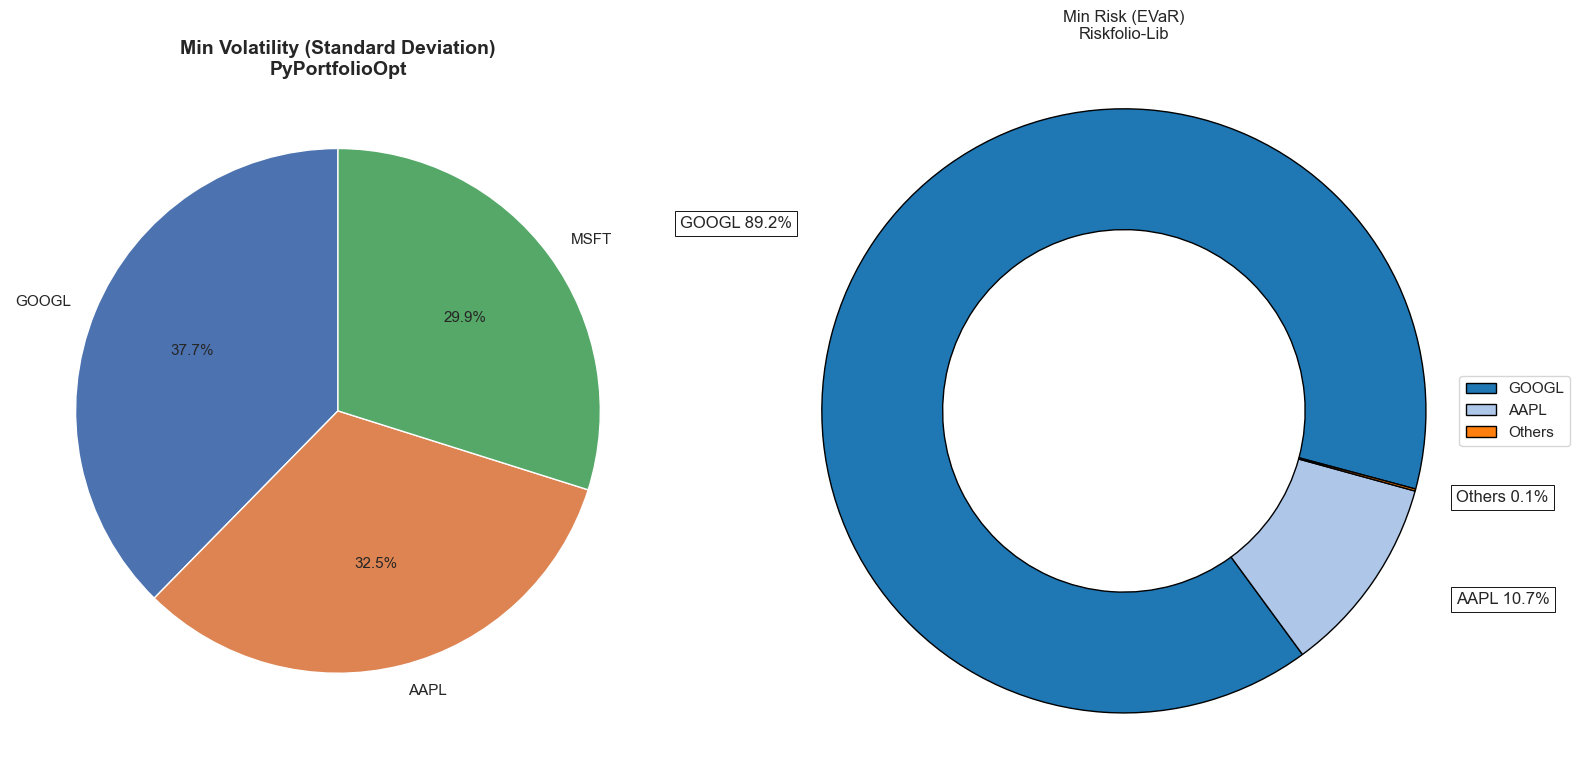

In [7]:
#1. MVO
print("--- Training: Optimizing n-Assets (Min Volatility) on Train Set ---")
ef_vol = EfficientFrontier(mu_train, S_train, weight_bounds=(0, 1))
w_vol = ef_vol.min_volatility()
cleaned_w_vol = ef_vol.clean_weights()

# 3. Print results
print("Static Weights found (n-MinVol):")
print(pd.Series(cleaned_w_vol))
print("\nPerformance (In-Sample, on Train Set):")
ef_vol.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

# 2 (Training) Optimize n-assets (Min Volatility) - EVaR
print(f"\n--- Training Optimize n-assets (Min EVaR) - Solver: Auto ---")

port_minvol = rp.Portfolio(returns=returns_train)
port_minvol.assets_stats(method_mu='hist', method_cov='hist')

w_evar_minvol = port_minvol.optimization(
    model='Classic',
    rm='EVaR',       
    obj='MinRisk',   
    rf=0,
    l=0,
    hist=True
)

#Display Weights
print("\n--- OPTIMAL WEIGHTS (Min EVaR) ---")
print(w_evar_minvol)

w_arr_risk = w_evar_minvol.values.flatten()           # shape (n,)
mu_arr_risk = port_minvol.mu.values.flatten()         # daily mean
cov_arr_risk = port_minvol.cov.values                 # daily cov matrix
ann_factor = 252

ret_annual_risk = float(np.sum(w_arr_risk * mu_arr_risk) * ann_factor)
vol_annual_risk = float(np.sqrt(w_arr_risk.T @ cov_arr_risk @ w_arr_risk) * np.sqrt(ann_factor))


port_ret_daily_risk = returns_train.values @ w_arr_risk   
raw_evar_risk = rp.RiskFunctions.EVaR_Hist(port_ret_daily_risk, alpha=0.05)
evar_daily_risk = float(raw_evar_risk[0] if isinstance(raw_evar_risk, (tuple, list, np.ndarray)) else raw_evar)
evar_annual_risk = evar_daily_risk * np.sqrt(ann_factor)

# Sharpe measured as Return / EVaR (since optimization used EVaR)
sharpe_evar = ret_annual_risk / evar_annual_risk if evar_annual_risk != 0 else np.nan

print("-" * 40)
print("Performance (In-Sample) - Min EVaR:")
print(f"Expected annual return: {ret_annual_risk:.2%}")
print(f"Annual volatility:      {vol_annual_risk:.2%}   (supplementary)")
print(f"Annual EVaR risk:       {evar_annual_risk:.2%}   (objective used)")
print(f"Sharpe (Return / EVaR): {sharpe_evar:.3f}")
print("-" * 40)
#3. PLOTTING
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
df_vol_plot = pd.DataFrame.from_dict(cleaned_w_vol, orient='index', columns=['Weight'])

df_vol_plot = df_vol_plot[df_vol_plot['Weight'] > 0.0001].sort_values('Weight', ascending=False)

df_vol_plot.plot(
    kind='pie',
    y='Weight',
    autopct='%1.1f%%',
    startangle=90,
    legend=False,
    ax=axes[0],       
    fontsize=11
)
axes[0].set_ylabel("")
axes[0].set_title("Min Volatility (Standard Deviation)\nPyPortfolioOpt", fontsize=14, fontweight='bold')

rp.plot_pie(
    w=w_evar_minvol,
    title='Min Risk (EVaR)\nRiskfolio-Lib',
    height=6,
    width=10,
    cmap="tab20",
    ax=axes[1]       
)

plt.tight_layout()
plt.show()

#### Observation:

### 2.5: Definition & Visualization of the Efficient Frontier (on Train Set)

- **Definition (Efficient Frontier):** The Efficient Frontier is a curve representing the set of "optimal" portfolios (based on the input data, here `train_data`).
- For any point on the frontier:
  1. No other portfolio exists with the same risk that offers a higher return.
  2. No other portfolio exists with the same return that has lower risk.
- All portfolios *below* the frontier are sub-optimal.

--- Visualizing Efficient Frontier (CLA Method) ---


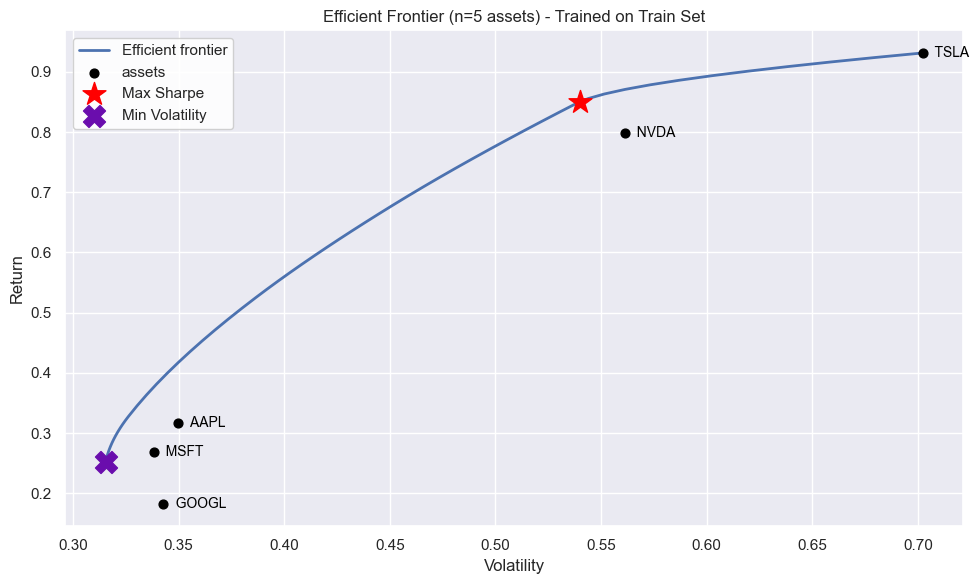

In [8]:

print("--- Visualizing Efficient Frontier (CLA Method) ---")

cla = CLA(mu_train, S_train)
cla.max_sharpe() # This method must be called first to solve the optimization
(ret_frontier, vol_frontier, _) = cla.efficient_frontier()

ret_sharpe, vol_sharpe, _ = ef_sharpe.portfolio_performance(risk_free_rate=risk_free_rate, verbose=False)
ret_minvol, vol_minvol, _ = ef_vol.portfolio_performance(risk_free_rate=risk_free_rate, verbose=False)

asset_vols = np.sqrt(np.diag(S_train))
asset_rets = mu_train.values
sns.set_style("darkgrid") 

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(vol_frontier, ret_frontier, color="#4c72b0", linewidth=2, label="Efficient frontier")

ax.scatter(asset_vols, asset_rets, marker='o', s=40, c='black', label='assets', zorder=5)
for i, ticker in enumerate(mu_train.index):
    ax.text(asset_vols[i] + 0.002, asset_rets[i], 
            f"  {ticker}", 
            fontsize=10, 
            color='black',
            verticalalignment='center')
ax.scatter(vol_sharpe, ret_sharpe, marker='*', s=300, c='red', label='Max Sharpe', zorder=10)
ax.scatter(vol_minvol, ret_minvol, marker='X', s=250, c='#6a0dad', label='Min Volatility', zorder=10)
ax.set_title(f"Efficient Frontier (n={len(tickers)} assets) - Trained on Train Set")
ax.set_xlabel("Volatility")
ax.set_ylabel("Return")
ax.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)

plt.tight_layout()
plt.show()

In [ ]:
rf = 0          
hist = True     
points = 15   
alpha = 0.05    

print(f"--- Visualizing Efficient Frontier (Mean-EVaR) ---")
print(f"Generating {points} points. This may take a moment due to EVaR complexity...")

hist_returns = port_sharpe.returns.tail(500)

solvers_to_try = ['CLARABEL', 'ECOS', 'SCS'] 
frontier = None

# --- CALCULATION PHASE ---
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    for solver in solvers_to_try:
        try:
            frontier = port_sharpe.efficient_frontier(
                model='Classic', 
                rm='EVaR', 
                points=points, 
                rf=rf,        
                hist=hist_returns,    
                solver=solver
            )
            break 
        except Exception:
            continue

    if frontier is None:
        try:
            frontier = port_sharpe.efficient_frontier(
                model='Classic', 
                rm='EVaR', 
                points=points, 
                rf=rf, 
                hist=hist_returns
            )
        except Exception as e:
            print(f"Critical Error: Could not calculate frontier. {e}")

# --- PLOTTING PHASE ---
if frontier is not None:
    label = 'Max Sharpe (EVaR)'
    mu = port_sharpe.mu
    cov = port_sharpe.cov
    returns = hist_returns  

    fig, ax = plt.subplots(figsize=(10, 6))
    try:
        w_star = w_evar 
    except NameError:
        w_star = None 

    rp.plot_frontier(
        w_frontier=frontier, 
        mu=mu, 
        cov=cov, 
        returns=returns, 
        rm='EVaR', 
        rf=rf, 
        alpha=alpha, 
        cmap='viridis', 
        w=w_star, 
        label=label, 
        marker='*', 
        s=16, 
        c='r', 
        height=6, 
        width=10, 
        ax=ax
    )

    ax.grid(True, linestyle='--', alpha=0.5)
    print("Plot generated successfully.")
    plt.show()
else:
    print("Skipping plot due to calculation failure.")

--- Visualizing Efficient Frontier (Mean-EVaR) ---
Generating 25 points. This may take a moment due to EVaR complexity...
Attempting solver: CLARABEL...


#### Observation (Part 2.2 - 2.5)

- The charts above show the optimization results *based only on the Train Set* (2 years of history).
- **Max Sharpe:** The Max Sharpe portfolio (red star) tries to balance risk and return.
- **Min Volatility:** The Min Vol portfolio (blue X) focuses only on minimizing risk.
- **Problem:** This is an "in-sample" result. We will check how these weights perform on the `test_data` in section 2.8.

### 2.6: (Training) Optimize $k$-of-$n$ assets (Max Sharpe) on Train Set

We will loop through all 15 combinations to find the $k$ tickers (and weights) that give the highest Sharpe Ratio, **using only `train_data`**.

In [9]:
print(f"--- STARTING k-of-n SEARCH (Max Sharpe) on Train Set ---")

# 1. Global tracking variables
global_best_sharpe_k = -np.inf
global_best_weights_k_sharpe = None
all_results_sharpe = [] 

# 2. Calculate base metrics (from mu_train, S_train already calculated in 2.2)
individual_vol_series_train = pd.Series(np.sqrt(np.diag(S_train)), index=tickers)
individual_sharpes_train = (mu_train - risk_free_rate) / individual_vol_series_train
individual_vol_train = individual_vol_series_train.to_dict()

# 3. Outer loop: Iterate k from 1 to n
for k in range(1, n + 1):
    # 4. Inner loop: Iterate combinations C(n, k)
    for combo in itertools.combinations(tickers, k):
        combo_list = list(combo)
        combo_str = str(combo)
        ret, vol, sharpe, weights_dict = (np.nan, np.nan, np.nan, {})

        try:
            # 5. Optimize for this combination
            if k == 1:
                ticker = combo_list[0]
                ret = mu_train[ticker]
                vol = individual_vol_train[ticker]
                sharpe = individual_sharpes_train[ticker]
                weights_dict = {ticker: 1.0}
            else:
                mu_combo = mu_train[combo_list]
                S_combo = S_train.loc[combo_list, combo_list]
                ef_combo = EfficientFrontier(mu_combo, S_combo, weight_bounds=(0, 1))
                weights = ef_combo.max_sharpe(risk_free_rate=risk_free_rate)
                ret, vol, sharpe = ef_combo.portfolio_performance(risk_free_rate=risk_free_rate)
                weights_dict = ef_combo.clean_weights()

            # 6. Track results
            if sharpe > global_best_sharpe_k:
                global_best_sharpe_k = sharpe
                global_best_weights_k_sharpe = weights_dict
            
            all_results_sharpe.append({'k': k, 'Combination': combo_str, 'Sharpe': sharpe, 'Volatility': vol, 'Return (APY)': ret, 'Weights': weights_dict})
        except Exception as e:
            pass 

# 7. Print final results
print("\n================ OPTIMAL RESULT (k-Max Sharpe) - TRAINING ================")
print(f"Highest Global Sharpe: {global_best_sharpe_k:.4f} (with k={len(global_best_weights_k_sharpe)}) ")
print("Static Weights found (k-MaxSharpe):")
print(pd.Series(global_best_weights_k_sharpe))

# 8. Print all results dataframe
all_results_sharpe_df = pd.DataFrame(all_results_sharpe).sort_values(by='Sharpe', ascending=False).reset_index(drop=True)
print("\n--- Top 15 Combinations (Ranked by Sharpe) ---")
print(all_results_sharpe_df[['k', 'Combination', 'Sharpe', 'Volatility']].head(10))

--- STARTING k-of-n SEARCH (Max Sharpe) on Train Set ---

================ OPTIMAL RESULT (k-Max Sharpe) - TRAINING ================
Highest Global Sharpe: 1.6245 (with k=1) 
Static Weights found (k-MaxSharpe):
TSLA    1.0
dtype: float64

--- Top 15 Combinations (Ranked by Sharpe) ---
   k                                Combination    Sharpe  Volatility
0  1                                  ('TSLA',)  1.624488    0.561119
1  3                  ('GOOGL', 'TSLA', 'NVDA')  1.537935    0.540041
2  3                   ('AAPL', 'TSLA', 'NVDA')  1.537935    0.540041
3  5  ('AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA')  1.537935    0.540041
4  4           ('AAPL', 'MSFT', 'TSLA', 'NVDA')  1.537935    0.540041
5  2                           ('TSLA', 'NVDA')  1.537935    0.540041
6  3                   ('MSFT', 'TSLA', 'NVDA')  1.537935    0.540041
7  4          ('AAPL', 'GOOGL', 'TSLA', 'NVDA')  1.537935    0.540041
8  4          ('MSFT', 'GOOGL', 'TSLA', 'NVDA')  1.537935    0.540041
9  3          

In [10]:
global_best_score = -np.inf
global_best_subset = None
all_results_evar = []

for k in range(1, n+1):
    for combo in itertools.combinations(tickers, k):
        subset = list(combo)
        combo_str = str(combo)
        
        # equal weight portfolio
        w = np.ones(len(subset)) / len(subset)
        port_ret = train_data[subset].dot(w)

        # annualized mean
        mean_val = float(port_ret.mean() * 252)

        # EVaR risk
        raw_evar = rp.RiskFunctions.EVaR_Hist(port_ret, alpha=0.05)
        evar_val = float(raw_evar[0] if isinstance(raw_evar, (tuple, list, np.ndarray)) else raw_evar)

        # Sharpe using EVaR
        score = mean_val / evar_val if evar_val != 0 else -np.inf  

        # Update best
        if score > global_best_score:
            global_best_score = score
            global_best_subset = subset

        all_results_evar.append({
            "k": k,
            "Combination": combo_str,
            "Mean(APY)": mean_val,
            "EVaR": evar_val,
            "Score(Mean/EVaR)": score,
            "Weights": {subset[i]: w[i] for i in range(k)}
        })

# Print results
print("\n================ OPTIMAL RESULT (Max Sharpe EVaR) ================")
print(f"Best Score: {global_best_score:.4f}")
print(f"Best Subset: {global_best_subset}")

df_evar = pd.DataFrame(all_results_evar).sort_values(by="Score(Mean/EVaR)", ascending=False)
print("\nTop 15:")
print(df_evar[['k','Combination','Score(Mean/EVaR)','Mean(APY)','EVaR']].head(10))



================ OPTIMAL RESULT (Max Sharpe EVaR) ================
Best Score: -429.4282
Best Subset: ['MSFT']

Top 15:
    k                        Combination  Score(Mean/EVaR)     Mean(APY)        EVaR
1   1                          ('MSFT',)       -429.428191  61500.428813 -143.214698
9   2                  ('MSFT', 'GOOGL')       -434.956010  43844.704150 -100.802617
11  2                   ('MSFT', 'NVDA')       -442.775604  33003.880871  -74.538616
22  3          ('MSFT', 'GOOGL', 'NVDA')       -444.246000  30732.247076  -69.178444
2   1                         ('GOOGL',)       -455.553149  26188.979487  -57.488307
15  3          ('AAPL', 'MSFT', 'GOOGL')       -458.587410  40359.307699  -88.007884
5   2                   ('AAPL', 'MSFT')       -460.729065  47444.471804 -102.976945
26  4  ('AAPL', 'MSFT', 'GOOGL', 'NVDA')       -465.185651  31396.314006  -67.492009
17  3           ('AAPL', 'MSFT', 'NVDA')       -469.168416  33132.092179  -70.618761
13  2                  ('GOOG

### 2.7: (Training) Optimize $k$-of-$n$ assets (Min Volatility) on Train Set

Same as 2.6, but finding the $k$ tickers with the lowest Risk.

In [19]:
print(f"--- STARTING k-of-n SEARCH (Min Volatility) on Train Set ---")

n = len(tickers)

# Map index for fast slicing
ticker_to_idx = {t: i for i, t in enumerate(tickers)}

# Convert mu, S to numpy for faster slicing
mu_np = mu_train[tickers].values
S_np = S_train.loc[tickers, tickers].values

global_best_vol = np.inf
global_best_weights = None
all_results = []

for k in range(1, n + 1):

    for combo in itertools.combinations(range(n), k):
        idx_list = list(combo)
        combo_tickers = [tickers[i] for i in idx_list]

        # Default values
        ret = vol = sharpe = np.nan
        weights_dict = {}

        # Case k = 1 (no optimizer needed)
        if k == 1:
            t = combo_tickers[0]
            ret = mu_train[t]
            vol = individual_vol_train[t]
            sharpe = individual_sharpes_train[t]
            weights_dict = {t: 1.0}

        # Case k ≥ 2
        else:
            mu_subset = mu_np[idx_list]
            S_subset = S_np[np.ix_(idx_list, idx_list)]

            try:
                ef = EfficientFrontier(mu_subset, S_subset, weight_bounds=(0, 1))
                ef.min_volatility()
                ret, vol, sharpe = ef.portfolio_performance(risk_free_rate=risk_free_rate)

                raw_w = ef.clean_weights()
                # Convert from index back to tickers
                weights_dict = {tickers[idx_list[i]]: w for i, w in enumerate(raw_w.values()) if w > 0}

            except Exception:
                continue

        # Track best result
        if vol < global_best_vol:
            global_best_vol = vol
            global_best_weights = weights_dict

        # Save results
        all_results.append({
            'k': k,
            'Combination': str(combo_tickers),
            'Volatility': vol,
            'Sharpe': sharpe,
            'Return (APY)': ret,
            'Weights': weights_dict
        })

# ============== OUTPUT ===============
print("\n================ OPTIMAL RESULT (k-Min Vol) - TRAINING ================")
print(f"Lowest Global Volatility: {global_best_vol:.4f} (with k={len(global_best_weights)})")
print("Static Weights found (k-MinVol):")
print(pd.Series(global_best_weights))

df = pd.DataFrame(all_results).sort_values(by='Volatility', ascending=True).reset_index(drop=True)

print("\n--- Top 15 Combinations (Ranked by Volatility) ---")
print(df[['k', 'Combination', 'Volatility', 'Sharpe']].head(10))


--- STARTING k-of-n SEARCH (Min Volatility) on Train Set ---

================ OPTIMAL RESULT (k-Min Vol) - TRAINING ================
Lowest Global Volatility: 0.3156 (with k=3)
Static Weights found (k-MinVol):
AAPL    0.3248
MSFT    0.2987
GOOGL   0.3765
dtype: float64

--- Top 15 Combinations (Ranked by Volatility) ---
   k                                Combination  Volatility  Sharpe
0  3                  ['AAPL', 'MSFT', 'GOOGL']      0.3156  0.7339
1  5  ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA']      0.3156  0.7339
2  4          ['AAPL', 'MSFT', 'GOOGL', 'NVDA']      0.3156  0.7339
3  4          ['AAPL', 'MSFT', 'GOOGL', 'TSLA']      0.3156  0.7339
4  3                  ['AAPL', 'GOOGL', 'NVDA']      0.3199  0.7031
5  2                          ['AAPL', 'GOOGL']      0.3199  0.7031
6  3                  ['AAPL', 'GOOGL', 'TSLA']      0.3199  0.7031
7  4          ['AAPL', 'GOOGL', 'TSLA', 'NVDA']      0.3199  0.7031
8  3                  ['MSFT', 'GOOGL', 'TSLA']      0.3233  0.64

In [12]:
global_best_evar = np.inf
global_best_subset = None
all_results_min_evar = []

print("\n--- STARTING k-of-n SEARCH (Min EVaR Risk) ---")

for k in range(1, n + 1):
    for combo in itertools.combinations(tickers, k):

        subset = list(combo)
        combo_str = str(combo)

        # equal-weight
        w = np.ones(len(subset)) / len(subset)
        port_ret = train_data[subset].dot(w)

        # EVaR
        raw_evar = rp.RiskFunctions.EVaR_Hist(port_ret, alpha=0.05)
        evar_val = float(raw_evar[0]) if isinstance(raw_evar, (tuple, list, np.ndarray)) else float(raw_evar)

        # mean return annualized (not used for objective, but saved)
        mean_val = float(port_ret.mean() * 252)

        # update best: minimize EVaR
        if evar_val < global_best_evar:
            global_best_evar = evar_val
            global_best_subset = subset

        # save results
        all_results_min_evar.append({
            "k": k,
            "Combination": combo_str,
            "Mean(APY)": mean_val,
            "EVaR": evar_val,
            "Weights": {subset[i]: w[i] for i in range(k)}
        })

# Final result
print("\n================ OPTIMAL RESULT (Min EVaR Risk) ================")
print(f"Lowest EVaR: {global_best_evar:.6f}")
print(f"Best Subset: {global_best_subset}")

df_min_evar = pd.DataFrame(all_results_min_evar).sort_values(by="EVaR", ascending=True)
print("\nTop 15 portfolios with lowest EVaR:")
print(df_min_evar[['k','Combination','EVaR','Mean(APY)']].head(10))


--- STARTING k-of-n SEARCH (Min EVaR Risk) ---

================ OPTIMAL RESULT (Min EVaR Risk) ================
Lowest EVaR: -143.214698
Best Subset: ['MSFT']

Top 15 portfolios with lowest EVaR:
    k                        Combination        EVaR     Mean(APY)
1   1                          ('MSFT',) -143.214698  61500.428813
5   2                   ('AAPL', 'MSFT') -102.976945  47444.471804
9   2                  ('MSFT', 'GOOGL') -100.802617  43844.704150
10  2                   ('MSFT', 'TSLA')  -88.604540  56529.061984
15  3          ('AAPL', 'MSFT', 'GOOGL')  -88.007884  40359.307699
16  3           ('AAPL', 'MSFT', 'TSLA')  -80.103321  48815.546255
21  3          ('MSFT', 'GOOGL', 'TSLA')  -78.702060  46415.701152
25  4  ('AAPL', 'MSFT', 'GOOGL', 'TSLA')  -74.672236  43158.904563
11  2                   ('MSFT', 'NVDA')  -74.538616  33003.880871
17  3           ('AAPL', 'MSFT', 'NVDA')  -70.618761  33132.092179


### 2.8: Performance Comparison (Out-of-Sample) on Test Set

This is the critical test. We will now apply the 5 sets of "Static Weights" we just trained (on `train_data`) to the `vad_data` (1 month of "future" data) to see how they actually perform.

In [15]:
w_mvo_sharpe = np.array(list(cleaned_weights_sharpe.values()))
w_mvo_minvol = np.array(list(cleaned_w_vol.values()))
w_evar_sharpe = w_evar.values.flatten()
w_evar_minrisk = w_evar_minvol.values.flatten()
w_k_mvo_sharpe = np.array([global_best_weights_k_sharpe.get(t, 0) for t in tickers])
w_k_evar_sharpe = np.array([1/len(global_best_subset) if t in global_best_subset else 0 for t in tickers])
w_k_mvo_minvol = np.array([global_best_weights.get(t, 0) for t in tickers])
w_k_evar_minrisk = np.array([1/len(global_best_subset) if t in global_best_subset else 0 for t in tickers])

weights_df = pd.DataFrame({
    "Ticker": tickers,
    "w_mvo_sharpe": w_mvo_sharpe,
    "w_mvo_minvol": w_mvo_minvol,
    "w_evar_sharpe": w_evar_sharpe,
    "w_evar_minrisk": w_evar_minrisk,
    "w_k_mvo_sharpe": w_k_mvo_sharpe,
    "w_k_evar_sharpe": w_k_evar_sharpe,
    "w_k_mvo_minvol": w_k_mvo_minvol,
    "w_k_evar_minrisk": w_k_evar_minrisk
})

pd.set_option('display.float_format', lambda x: f'{x:.4f}')  
print(weights_df)


  Ticker  w_mvo_sharpe  w_mvo_minvol  w_evar_sharpe  w_evar_minrisk  w_k_mvo_sharpe  w_k_evar_sharpe  w_k_mvo_minvol  w_k_evar_minrisk
0   AAPL        0.0000        0.3248         0.0000          0.1065          0.0000           0.0000          0.3248            0.0000
1   MSFT        0.0000        0.3765         0.0000          0.8924          0.0000           1.0000          0.2987            1.0000
2  GOOGL        0.0000        0.2987         0.0000          0.0006          0.0000           0.0000          0.3765            0.0000
3   TSLA        0.6087        0.0000         0.4521          0.0002          1.0000           0.0000          0.0000            0.0000
4   NVDA        0.3913        0.0000         0.5479          0.0002          0.0000           0.0000          0.0000            0.0000


--- FINAL CUMULATIVE RETURN VALUES ---
MVO Max Sharpe:     1.6885
EVaR Max Sharpe:    1.4237
k-of-n Max Sharpe:  2.4650
GOOGL Benchmark:      1.3439
----------------------------------------


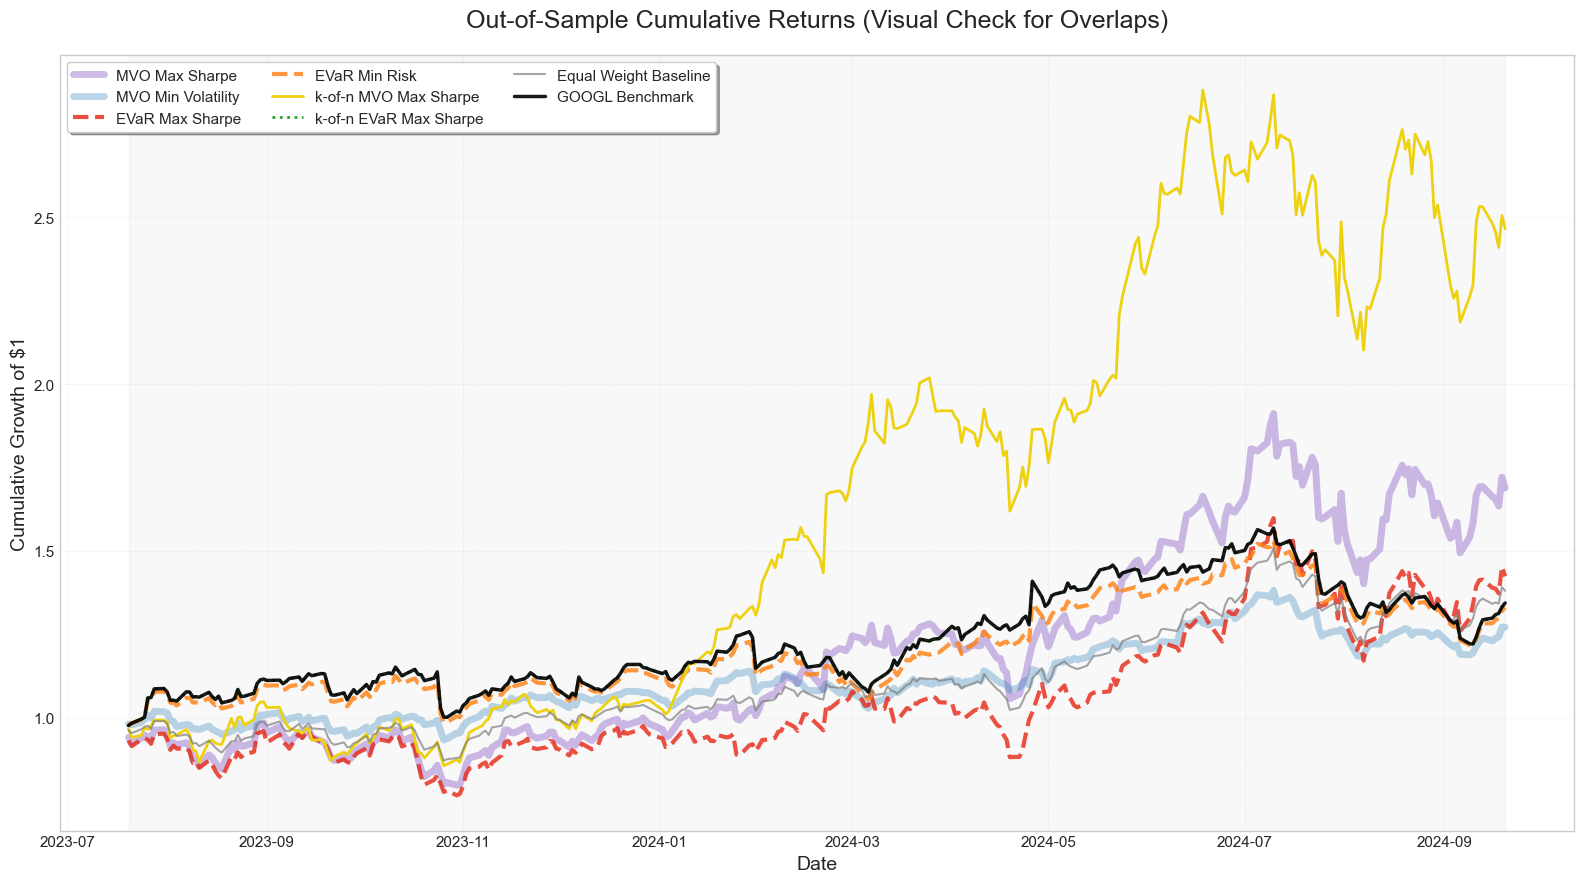

In [33]:
valid_returns = valid_data.pct_change().dropna()
def compute_cumret(weights, valid_returns):
    """
    weights: numpy array (shape = n_assets)
    valid_returns: DataFrame returns (T x n)
    """
    port_ret = (valid_returns * weights).sum(axis=1)
    cumret = (1 + port_ret).cumprod()
    return cumret

cum_mvo_sharpe    = compute_cumret(w_mvo_sharpe, valid_returns)
cum_mvo_minvol    = compute_cumret(w_mvo_minvol, valid_returns)

cum_evar_sharpe   = compute_cumret(w_evar_sharpe, valid_returns)
cum_evar_minrisk  = compute_cumret(w_evar_minrisk, valid_returns)

cum_k_mvo_sharpe  = compute_cumret(w_k_mvo_sharpe, valid_returns)
cum_k_evar_sharpe = compute_cumret(w_k_evar_sharpe, valid_returns)

w_equal = np.ones(len(valid_returns.columns)) / len(valid_returns.columns)
cum_equal = compute_cumret(w_equal, valid_returns)

#Benchmark
def cum_benchmark(returns_df, ticker):
    if ticker in returns_df.columns:
        return (1 + returns_df[ticker]).cumprod()
    else:
        return None
benchmark_choice = "GOOGL"  
cum_bmark = cum_benchmark(valid_returns, benchmark_choice)


# =============================================
print("--- FINAL CUMULATIVE RETURN VALUES ---")
print(f"MVO Max Sharpe:     {cum_mvo_sharpe.iloc[-1]:.4f}")
print(f"EVaR Max Sharpe:    {cum_evar_sharpe.iloc[-1]:.4f}")
print(f"k-of-n Max Sharpe:  {cum_k_mvo_sharpe.iloc[-1]:.4f}")
print(f"GOOGL Benchmark:      {cum_bmark.iloc[-1] if cum_bmark is not None else 0:.4f}")
print("-" * 40)

plt.figure(figsize=(16, 9))
plt.style.use('seaborn-v0_8-whitegrid')

plt.plot(cum_mvo_sharpe, label='MVO Max Sharpe', 
         color="#5d1fb4", linewidth=5, alpha=0.3, linestyle='-') 
plt.plot(cum_mvo_minvol, label='MVO Min Volatility', 
         color="#1f77b4", linewidth=5, alpha=0.3, linestyle='-')

plt.plot(cum_evar_sharpe, label='EVaR Max Sharpe', 
         color="#e62614", linewidth=3, alpha=0.8, linestyle='--')
plt.plot(cum_evar_minrisk, label='EVaR Min Risk', 
         color="#ff7f0e", linewidth=3, alpha=0.8, linestyle='--')

plt.plot(cum_k_mvo_sharpe, label='k-of-n MVO Max Sharpe', 
         color="#eed111", linewidth=2, alpha=1.0, linestyle='-')
plt.plot(cum_k_evar_sharpe, label='k-of-n EVaR Max Sharpe', 
         color="#2ca02c", linewidth=2, alpha=1.0, linestyle=':')

plt.plot(cum_equal, label='Equal Weight Baseline', 
         color="#7f7f7f", linewidth=1.5, alpha=0.7, linestyle='-')

if cum_bmark is not None:
    plt.plot(cum_bmark, label='GOOGL Benchmark', 
             color="black", linewidth=2.5, linestyle='-', alpha=0.9, zorder=10)

plt.axvspan(valid_returns.index[0], valid_returns.index[-1], color='gray', alpha=0.05)
plt.title("Out-of-Sample Cumulative Returns (Visual Check for Overlaps)", fontsize=18, pad=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Growth of $1", fontsize=14)
plt.legend(ncol=3, fontsize=11, loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.9: Metrics Analysis & Conclusion (Test Set)

Compare the metrics of the 5 strategies on the validation set.

In [34]:
def calculate_performance_metrics_pro(portfolio_value_series, risk_free_rate=0.02):

    # daily returns
    ret = portfolio_value_series.pct_change().dropna()
    if ret.empty:
        return pd.Series({})

    ann_factor = 252

    # Return metrics
    ann_ret = (1 + ret.mean())**ann_factor - 1
    cum_ret = portfolio_value_series.iloc[-1] / portfolio_value_series.iloc[0] - 1

    # Volatility
    vol = ret.std() * np.sqrt(ann_factor)

    # Sharpe
    sharpe = (ann_ret - risk_free_rate) / vol if vol > 0 else np.nan

    # Sortino
    downside = ret[ret < 0].std() * np.sqrt(ann_factor)
    sortino = (ann_ret - risk_free_rate) / downside if downside > 0 else np.nan

    # Drawdown + Calmar
    cum_curve = (1 + ret).cumprod()
    peak = cum_curve.cummax()
    dd = (cum_curve - peak) / peak
    max_dd = dd.min()
    calmar = ann_ret / abs(max_dd) if max_dd < 0 else np.nan

    # Hit ratio
    hit_ratio = (ret > 0).mean()

    # Tail risk metrics
    var_95 = np.percentile(ret, 5)
    cvar_95 = ret[ret <= var_95].mean()

    # Distribution shape
    skewness = skew(ret)
    kurt = kurtosis(ret)

    return pd.Series({
        "Cumulative Return": cum_ret,
        "Annualized Return (APY)": ann_ret,
        "Annualized Volatility": vol,
        "Sharpe Ratio (rf=2%)": sharpe,
        "Sortino Ratio": sortino,
        "Max Drawdown": max_dd,
        "Calmar Ratio": calmar,
        "Hit Ratio (Win %)": hit_ratio,
        "VaR 95%": var_95,
        "CVaR 95%": cvar_95,
        "Skewness": skewness,
        "Kurtosis": kurt
    })


In [35]:
strategy_curves = {
    "MVO_MaxSharpe"       : cum_mvo_sharpe,
    "MVO_MinVol"          : cum_mvo_minvol,
    "EVaR_MaxSharpe"      : cum_evar_sharpe,
    "EVaR_MinRisk"        : cum_evar_minrisk,
    "k_MVO_MaxSharpe"     : cum_k_mvo_sharpe,
    "k_EVaR_MaxSharpe"    : cum_k_evar_sharpe,
    "Equal_Weight"        : cum_equal,
}
if cum_bmark is not None:
    benchmark_name = f"{benchmark_choice}_Benchmark"
    strategy_curves[benchmark_name] = cum_bmark
static_cumulative_returns = pd.DataFrame(strategy_curves)

all_metrics = {}
for strategy in static_cumulative_returns.columns:
    all_metrics[strategy] = calculate_performance_metrics_pro(
        static_cumulative_returns[strategy]
    )

bench_cols = [c for c in metrics_df.index if "_Benchmark" in c]

if bench_cols:
    bench = metrics_df.loc[bench_cols]
    rest = metrics_df.drop(index=bench_cols)
    rest = rest.sort_values(by='Sharpe Ratio (rf=2%)', ascending=False)
    metrics_df = pd.concat([rest, bench])
else:
    metrics_df = metrics_df.sort_values(by='Sharpe Ratio (rf=2%)', ascending=False)

# ----- Print -----
print(f"--- FINAL METRICS (Out-of-Sample Test {len(valid_data)} days) ---")
print(metrics_df.to_string(float_format="{:.2%}".format))

--- FINAL METRICS (Out-of-Sample Test 297 days) ---
                  Cumulative Return  Annualized Return (APY)  Annualized Volatility  Sharpe Ratio (rf=2%)  Sortino Ratio  Max Drawdown  Calmar Ratio  Hit Ratio (Win %)  VaR 95%  CVaR 95%  Skewness  Kurtosis
k_MVO_MaxSharpe             154.93%                  152.13%                 50.51%               297.21%        487.32%       -27.05%       562.46%             55.59%   -4.45%    -6.44%    45.57%   285.05%
MVO_MaxSharpe                79.29%                   79.82%                 42.13%               184.73%        284.93%       -26.66%       299.39%             53.90%   -4.07%    -5.63%     4.29%   127.07%
Equal_Weight                 43.35%                   40.28%                 24.86%               153.96%        230.76%       -18.93%       212.82%             55.93%   -2.48%    -3.49%   -31.46%    75.72%
MVO_MinVol                   29.60%                   27.09%                 19.09%               131.42%        181.16%

### Observation (Conclusion for Part 2)

- **Result:** The table above shows the objective comparison of the 5 strategies on the 1-month test set.
- **Analysis:** (Results may vary). Often, the Min Volatility strategies (both $n$ and $k$) will show stability and a low Max Drawdown. The Max Sharpe strategies, which were trained to maximize return/risk in the past (Train Set), may perform very well or very poorly in the Test Set, depending on market conditions.
- **Conclusion:** This is a fundamental workflow for "out-of-sample" testing. It demonstrates that the "best" portfolio from the past (in-sample) is not guaranteed to be the best in the future (out-of-sample).

## Part 3: Recommendations

### 3.1: SMA Calculation & Setup

--- Signal Charts for 5 Assets (Train Phase) ---


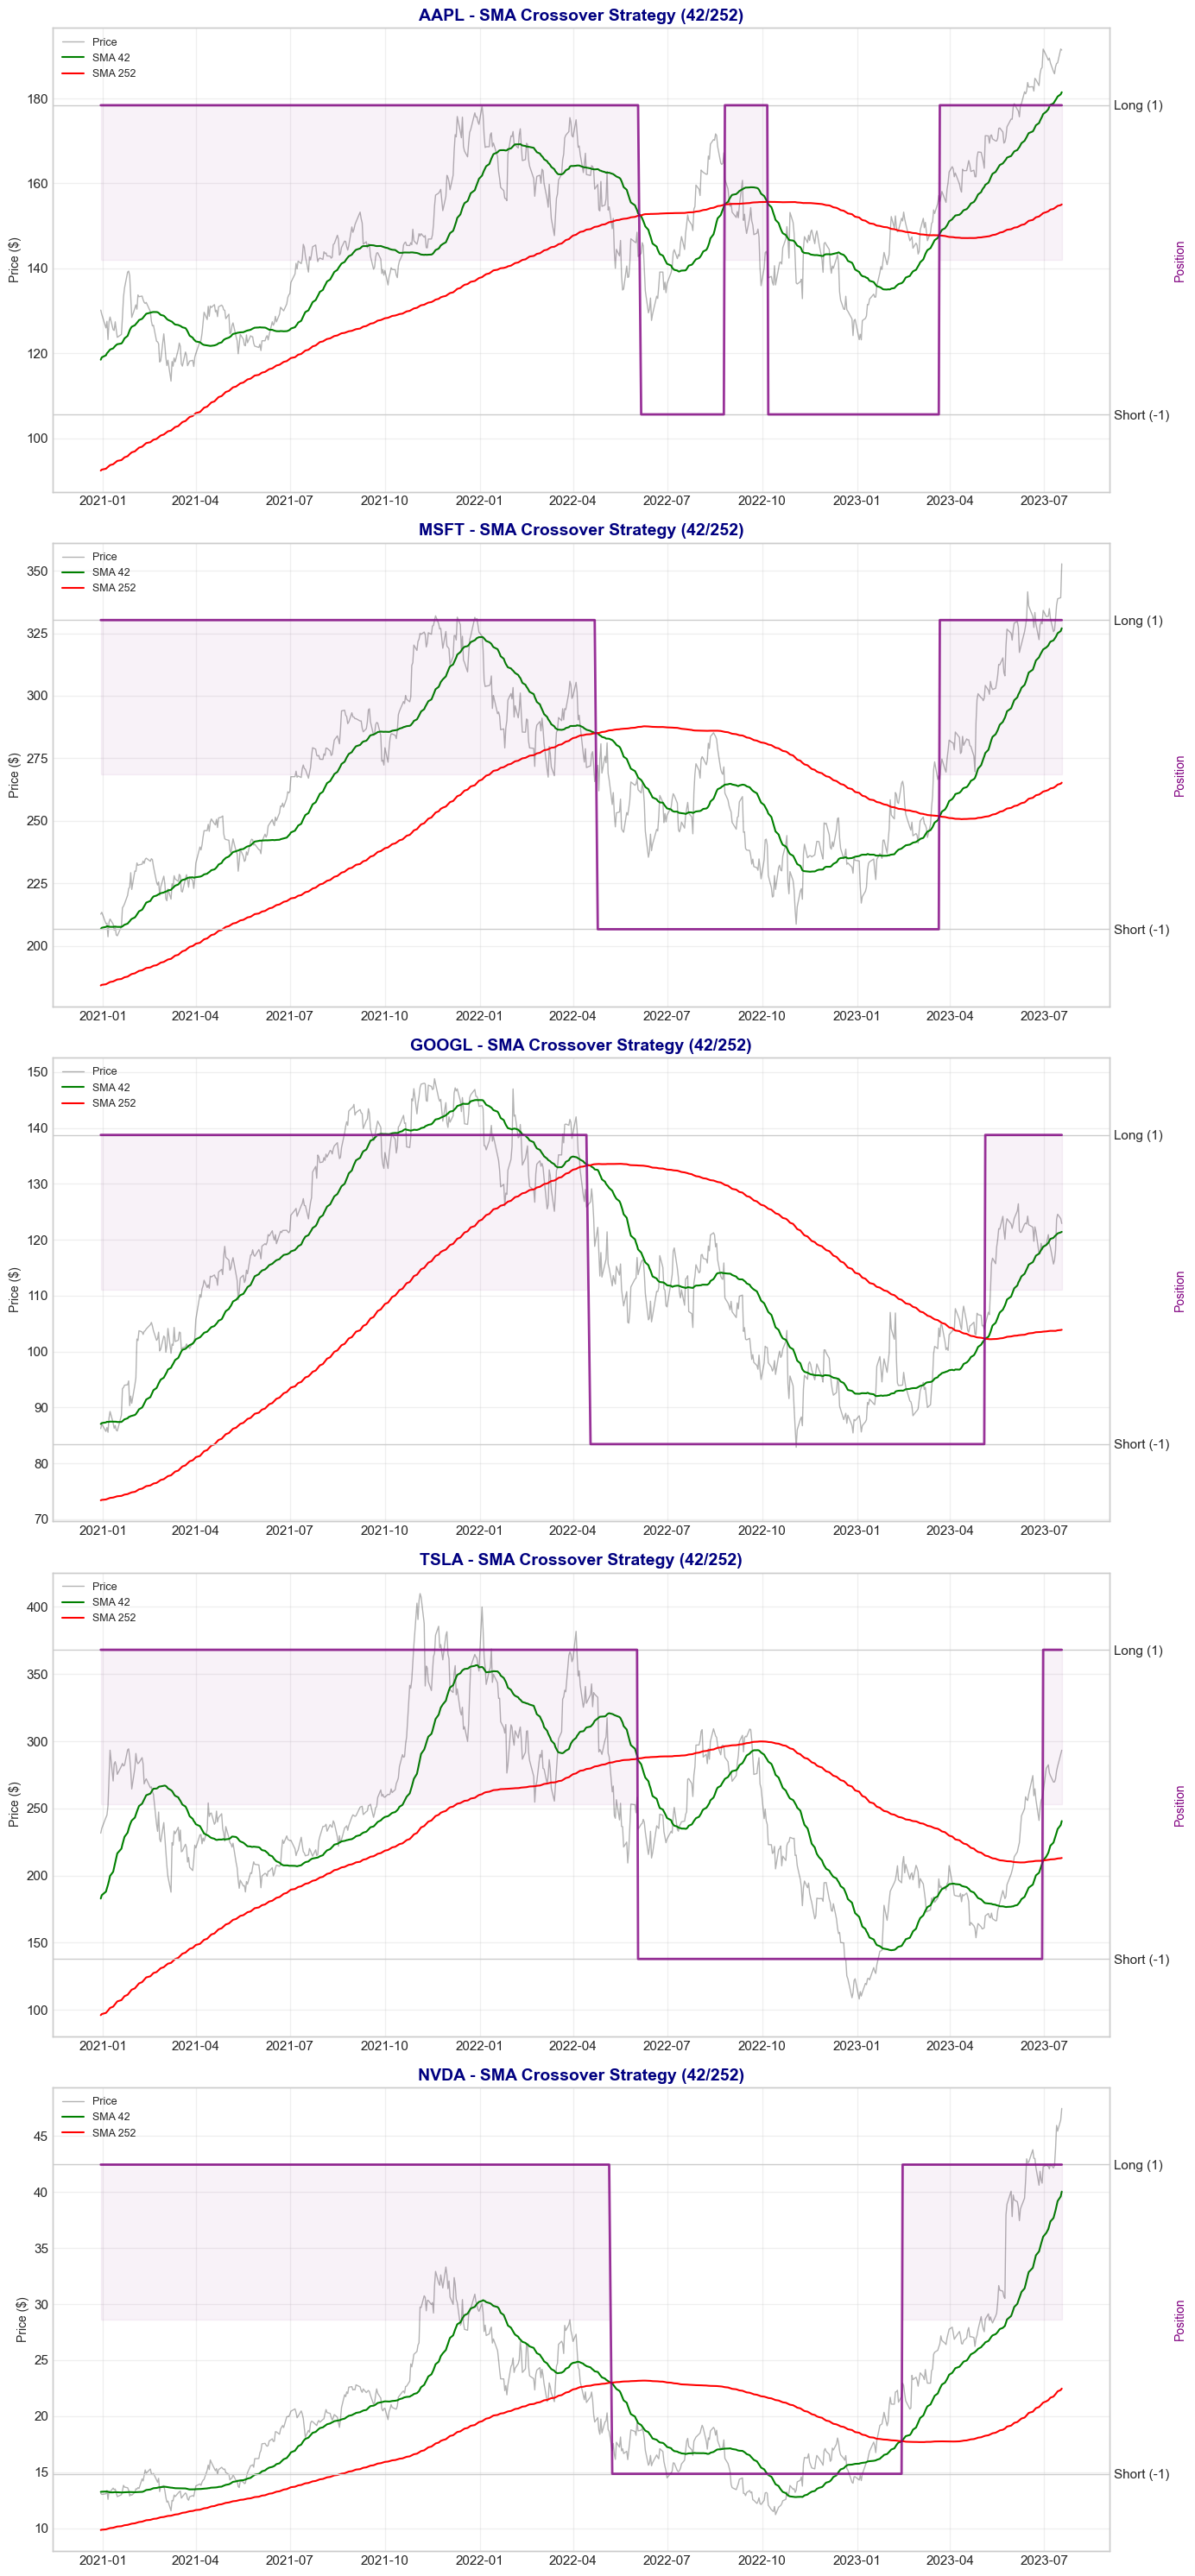

In [28]:
SMA1 = 42   # Short window
SMA2 = 252  # Long window

df_base = train_data.copy()

print(f"--- Signal Charts for {len(tickers)} Assets (Train Phase) ---")

fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(14, 30))

for i, ticker in enumerate(tickers):
    df_asset = df_base[[ticker]].rename(columns={ticker: 'Price'})
    
    df_asset['SMA1'] = df_asset['Price'].rolling(SMA1).mean()
    df_asset['SMA2'] = df_asset['Price'].rolling(SMA2).mean()
    
    df_asset.dropna(inplace=True)
    
    df_asset['Position'] = np.where(df_asset['SMA1'] > df_asset['SMA2'], 1, -1)
    
    ax1 = axes[i] 
    
    # --- Price & SMA ---
    ax1.plot(df_asset.index, df_asset['Price'], label='Price', color='black', alpha=0.3, linewidth=1)
    ax1.plot(df_asset.index, df_asset['SMA1'], label=f'SMA {SMA1}', color='green', linewidth=1.5)
    ax1.plot(df_asset.index, df_asset['SMA2'], label=f'SMA {SMA2}', color='red', linewidth=1.5)
    ax1.set_ylabel('Price ($)', fontsize=10)
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # --- Position ---
    ax2 = ax1.twinx()
    ax2.plot(df_asset.index, df_asset['Position'], label='Position', color='purple', linestyle='-', linewidth=2, alpha=0.8)
    
    ax2.set_ylabel('Position', color='purple', fontsize=10)
    ax2.set_yticks([-1, 1])
    ax2.set_yticklabels(['Short (-1)', 'Long (1)']) 
    ax2.set_ylim(-1.5, 1.5) 
    
    ax2.fill_between(df_asset.index, df_asset['Position'], 0, 
                     where=(df_asset['Position']==1), color='purple', alpha=0.05)
    
    ax1.set_title(f"{ticker} - SMA Crossover Strategy ({SMA1}/{SMA2})", fontsize=14, fontweight='bold', color='navy')

plt.tight_layout()
plt.show()

### 3.2: Vectorized Backtesting (on train set)

--- Vectorized Backtesting on TRAIN DATA ---


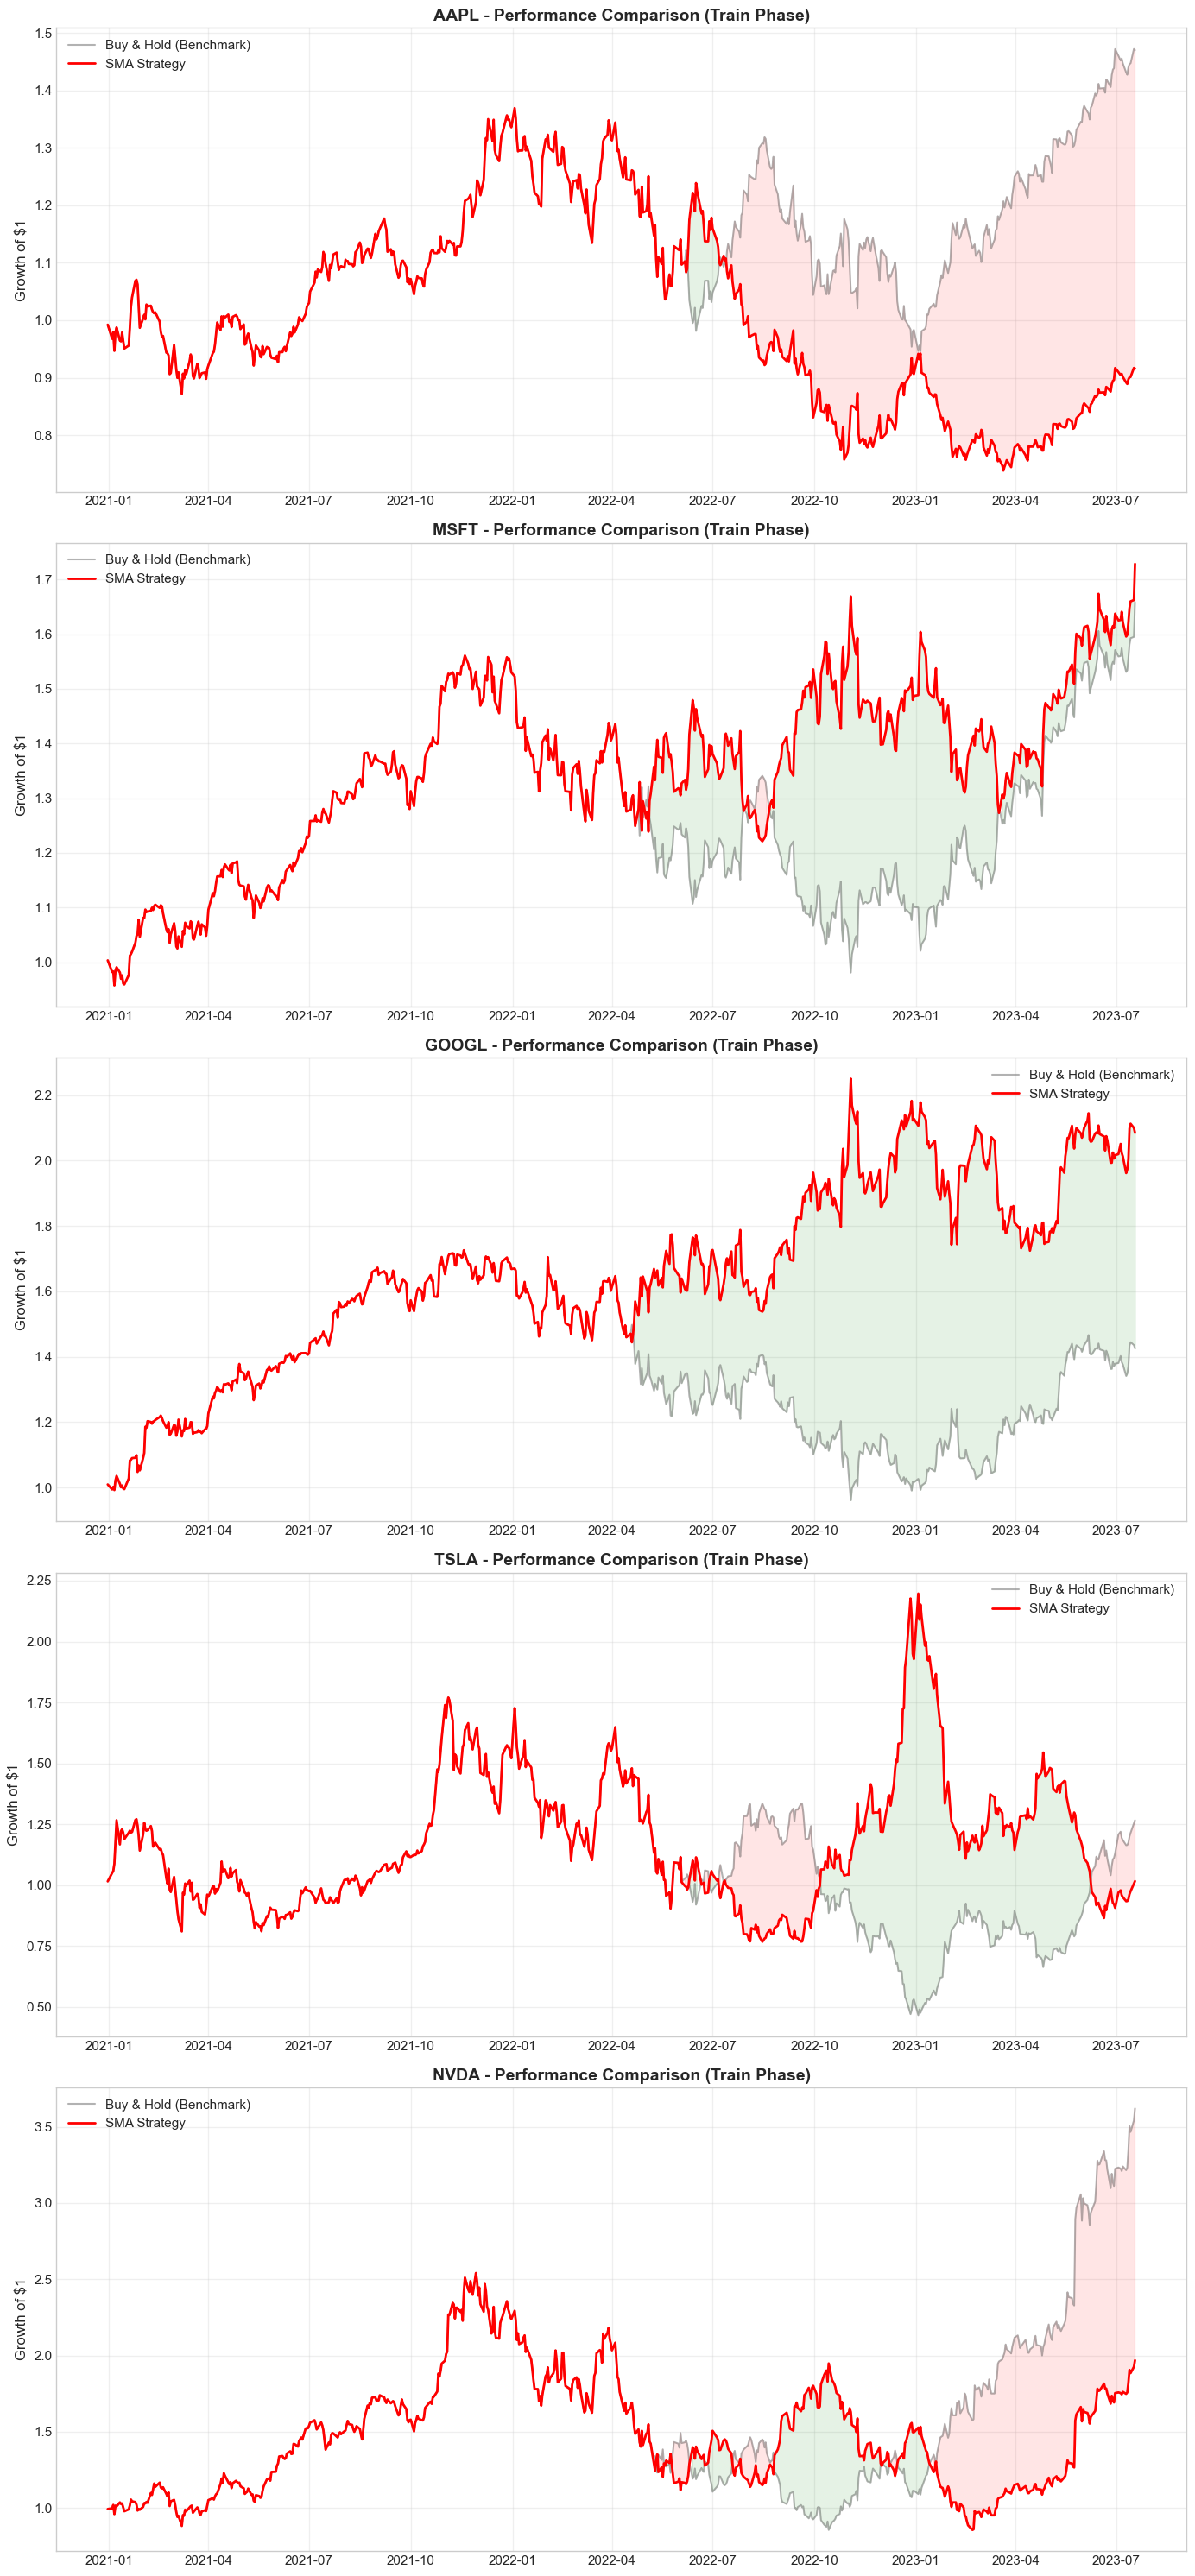


=== PERFORMANCE SUMMARY TABLE (TRAIN PHASE) ===
     Ticker     Buy&Hold Return SMA Strategy Return  Outperformance Strategy Volatility
      AAPL           47.04%            -8.43%            -55.47%           29.05%      
      MSFT           65.83%            72.85%              7.02%           28.87%      
     GOOGL           42.56%           108.52%             65.96%           32.40%      
      TSLA           26.66%             1.66%            -25.00%           60.56%      
      NVDA          262.04%            96.82%           -165.22%           54.81%      


In [36]:
df_backtest = train_data.copy()
print(f"--- Vectorized Backtesting on TRAIN DATA ---")

performance_metrics = []

fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(14, 30))

for i, ticker in enumerate(tickers):
    data = df_backtest[[ticker]].rename(columns={ticker: 'Price'}).dropna()
    
    data['SMA1'] = data['Price'].rolling(SMA1).mean()
    data['SMA2'] = data['Price'].rolling(SMA2).mean()
    data.dropna(inplace=True) 
    
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    
    data['Market_Ret'] = np.log(data['Price'] / data['Price'].shift(1))
    
    data['Strategy_Ret'] = data['Position'].shift(1) * data['Market_Ret']
    
    data.dropna(inplace=True)
    
    # CUMULATIVE RETURN
    data['Cum_Market'] = data['Market_Ret'].cumsum().apply(np.exp)
    data['Cum_Strategy'] = data['Strategy_Ret'].cumsum().apply(np.exp)
    
    # PERFORMANCE METRICS
    final_market_ret = data['Cum_Market'].iloc[-1] - 1
    final_strategy_ret = data['Cum_Strategy'].iloc[-1] - 1
    
    # Annualized Volatility 
    vol_market = data['Market_Ret'].std() * (252 ** 0.5)
    vol_strategy = data['Strategy_Ret'].std() * (252 ** 0.5)
    

    performance_metrics.append({
        'Ticker': ticker,
        'Buy&Hold Return': final_market_ret,
        'SMA Strategy Return': final_strategy_ret,
        'Outperformance': final_strategy_ret - final_market_ret, 
        'Strategy Volatility': vol_strategy
    })
    

    ax = axes[i]
    ax.plot(data.index, data['Cum_Market'], label='Buy & Hold (Benchmark)', color='grey', alpha=0.6, linewidth=1.5)
    ax.plot(data.index, data['Cum_Strategy'], label='SMA Strategy', color='red', linewidth=2)
    
    ax.set_title(f"{ticker} - Performance Comparison (Train Phase)", fontsize=14, fontweight='bold')
    ax.set_ylabel('Growth of $1')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax.fill_between(data.index, data['Cum_Strategy'], data['Cum_Market'], 
                    where=(data['Cum_Strategy'] > data['Cum_Market']), color='green', alpha=0.1, label='Win')
    ax.fill_between(data.index, data['Cum_Strategy'], data['Cum_Market'], 
                    where=(data['Cum_Strategy'] < data['Cum_Market']), color='red', alpha=0.1, label='Loss')

plt.tight_layout()
plt.show()

print("\n=== PERFORMANCE SUMMARY TABLE (TRAIN PHASE) ===")

display_df = pd.DataFrame(performance_metrics).copy()

cols_to_format = ['Buy&Hold Return', 'SMA Strategy Return', 'Outperformance', 'Strategy Volatility']
for col in cols_to_format:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.2%}")

print(display_df.to_string(index=False, col_space=15, justify='center'))

### 3.3: Optimization

In [37]:
sma1_range = range(20, 65, 5)
sma2_range = range(150, 270, 10)

df_opt = train_data.copy()

print(f"---  Optimization (Grid Search) on TRAIN DATA ---")
print(f"Testing {len(sma1_range) * len(sma2_range)} combinations per asset...")

best_results = []

for ticker in tickers:
    data = df_opt[[ticker]].rename(columns={ticker: 'Price'}).dropna()
    data['Market_Ret'] = np.log(data['Price'] / data['Price'].shift(1))
    
    best_perf = -np.inf
    best_params = (0, 0)
    
    for s, l in product(sma1_range, sma2_range):
        if s >= l: continue 
        sma_s = data['Price'].rolling(s).mean()
        sma_l = data['Price'].rolling(l).mean()
        
        position = np.where(sma_s > sma_l, 1, -1)
        strategy_ret = pd.Series(position).shift(1).values * data['Market_Ret'].values
        
        valid_idx = ~np.isnan(strategy_ret)
        total_ret = np.exp(np.sum(strategy_ret[valid_idx])) - 1
        
        if total_ret > best_perf:
            best_perf = total_ret
            best_params = (s, l)
    
    best_results.append({
        'Ticker': ticker,
        'Best SMA Short': best_params[0],
        'Best SMA Long': best_params[1],
        'Max Return (Train)': best_perf
    })

results_df = pd.DataFrame(best_results)
print("\n=== OPTIMIZATION RESULTS (TRAIN PHASE) ===")
print(results_df.to_string(index=False))


---  Optimization (Grid Search) on TRAIN DATA ---
Testing 108 combinations per asset...

=== OPTIMIZATION RESULTS (TRAIN PHASE) ===
Ticker  Best SMA Short  Best SMA Long  Max Return (Train)
  AAPL              60            180              0.1857
  MSFT              35            180              1.0018
 GOOGL              40            150              2.0500
  TSLA              60            150              0.5612
  NVDA              60            160              4.4511


### 3.4: Best SMA for Portfolio: Selection on validation test

In [47]:
print("--- OPTIMIZED PORTFOLIO: EVAR Max Sharpe + OPTIMIZED SMA ---")


final_weights_evar = w_evar['weights'].to_dict()

full_data = pd.concat([train_data, valid_data, test_data]).drop_duplicates().sort_index()
returns = full_data.pct_change().dropna()

# Calculate Portfolio Return based on EVaR weights
w_arr = np.array([final_weights.get(col, 0) for col in full_data.columns])
port_ret = returns.dot(w_arr)

# Calculate Cumulative Wealth (NAV), normalized to start at 1
port_nav = (1 + port_ret).cumprod()
port_nav = port_nav / port_nav.iloc[0]

train_nav = port_nav.loc[train_data.index.intersection(port_nav.index)]
valid_nav = port_nav.loc[valid_data.index.intersection(port_nav.index)]
test_nav  = port_nav.loc[test_data.index.intersection(port_nav.index)]

# -------------------------------------------------------
# 3. TRAINING & VALIDATION (Find Best SMA for Portfolio)
# -------------------------------------------------------
print("--> Optimizing SMA parameters for the entire portfolio...")

candidates = []
# Grid Search on Train Set
for s, l in product(range(20, 65, 5), range(120, 210, 10)):
    if s >= l: continue
    
    # Calculation on Train
    sma_s = train_nav.rolling(s).mean()
    sma_l = train_nav.rolling(l).mean()
    pos = np.where(sma_s > sma_l, 1, 0)
    
    strat_ret = pd.Series(pos).shift(1).fillna(0).values * port_ret.loc[train_nav.index].values
    total_ret = np.prod(1 + strat_ret) - 1
    
    candidates.append({'s': s, 'l': l, 'Train_Ret': total_ret})

# Get Top 5 best pairs from Train set
top_5 = sorted(candidates, key=lambda x: x['Train_Ret'], reverse=True)[:5]

# Validate Top 5 on VALIDATION set to select the Winner
best_valid_ret = -np.inf
winner_params = (0, 0)

for cand in top_5:
    s, l = cand['s'], cand['l']
    # Test on Validation Set
    sma_s = valid_nav.rolling(s).mean()
    sma_l = valid_nav.rolling(l).mean()
    pos = np.where(sma_s > sma_l, 1, 0)
    
    strat_ret_val = pd.Series(pos).shift(1).fillna(0).values * port_ret.loc[valid_nav.index].values
    valid_ret_val = np.prod(1 + strat_ret_val) - 1
    
    if valid_ret_val > best_valid_ret:
        best_valid_ret = valid_ret_val
        winner_params = (s, l)

final_evar_s, final_evar_l = winner_params
print(f"--> WINNING PARAMETERS: SMA({final_evar_s}, {final_evar_l})")

--- OPTIMIZED PORTFOLIO: EVAR Max Sharpe + OPTIMIZED SMA ---
--> Optimizing SMA parameters for the entire portfolio...
--> WINNING PARAMETERS: SMA(30, 120)


In [48]:
print("--- OPTIMIZED PORTFOLIO: MVO Max Sharpe + OPTIMIZED SMA ---")


final_weights_mvo = cleaned_weights_sharpe

full_data = pd.concat([train_data, valid_data, test_data]).drop_duplicates().sort_index()
returns = full_data.pct_change().dropna()

# Calculate Portfolio Return based on EVaR weights
w_arr = np.array([final_weights.get(col, 0) for col in full_data.columns])
port_ret = returns.dot(w_arr)

# Calculate Cumulative Wealth (NAV), normalized to start at 1
port_nav = (1 + port_ret).cumprod()
port_nav = port_nav / port_nav.iloc[0]

train_nav = port_nav.loc[train_data.index.intersection(port_nav.index)]
valid_nav = port_nav.loc[valid_data.index.intersection(port_nav.index)]
test_nav  = port_nav.loc[test_data.index.intersection(port_nav.index)]

# -------------------------------------------------------
# 3. TRAINING & VALIDATION (Find Best SMA for Portfolio)
# -------------------------------------------------------
print("--> Optimizing SMA parameters for the entire portfolio...")

candidates = []
# Grid Search on Train Set
for s, l in product(range(20, 65, 5), range(120, 210, 10)):
    if s >= l: continue
    
    # Calculation on Train
    sma_s = train_nav.rolling(s).mean()
    sma_l = train_nav.rolling(l).mean()
    pos = np.where(sma_s > sma_l, 1, 0)
    
    strat_ret = pd.Series(pos).shift(1).fillna(0).values * port_ret.loc[train_nav.index].values
    total_ret = np.prod(1 + strat_ret) - 1
    
    candidates.append({'s': s, 'l': l, 'Train_Ret': total_ret})

# Get Top 5 best pairs from Train set
top_5 = sorted(candidates, key=lambda x: x['Train_Ret'], reverse=True)[:5]

# Validate Top 5 on VALIDATION set to select the Winner
best_valid_ret = -np.inf
winner_params = (0, 0)

for cand in top_5:
    s, l = cand['s'], cand['l']
    # Test on Validation Set
    sma_s = valid_nav.rolling(s).mean()
    sma_l = valid_nav.rolling(l).mean()
    pos = np.where(sma_s > sma_l, 1, 0)
    
    strat_ret_val = pd.Series(pos).shift(1).fillna(0).values * port_ret.loc[valid_nav.index].values
    valid_ret_val = np.prod(1 + strat_ret_val) - 1
    
    if valid_ret_val > best_valid_ret:
        best_valid_ret = valid_ret_val
        winner_params = (s, l)

final_mvo_s, final_mvo_l = winner_params
print(f"--> WINNING PARAMETERS: SMA({final_mvo_s}, {final_mvo_l})")

--- OPTIMIZED PORTFOLIO: MVO Max Sharpe + OPTIMIZED SMA ---
--> Optimizing SMA parameters for the entire portfolio...
--> WINNING PARAMETERS: SMA(30, 120)


### 3.5: OUT-OF-SAMPLE PERFORMANCE:Intergrate portfolio optimization and strategy


   PERFORMANCE EVALUATION: EVAR PORTFOLIO (VALIDATION SET)


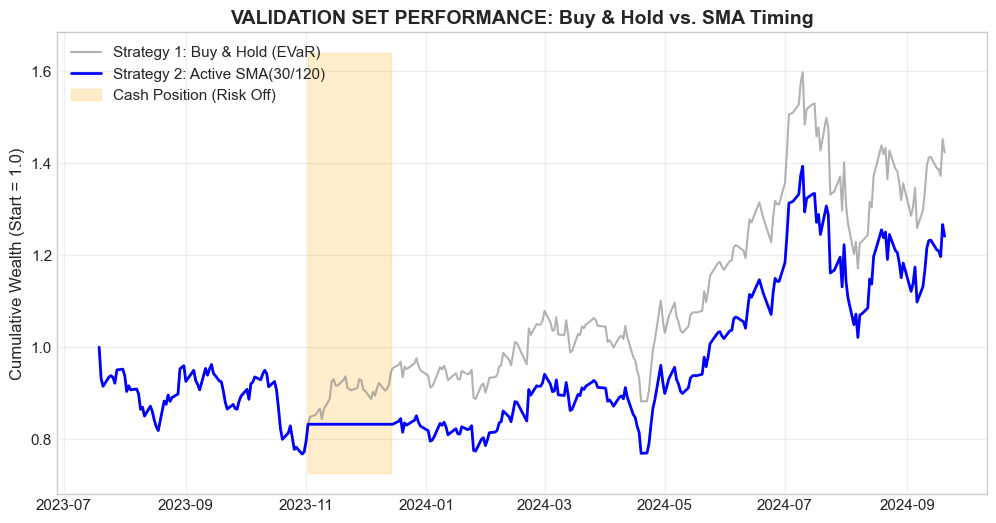


--- Result in VALIDATION using EVaR ---
Total Return: 24.15%
Max Drawdown: -26.73%


In [53]:
print("   PERFORMANCE EVALUATION: EVAR PORTFOLIO (VALIDATION SET)")
full_data = pd.concat([train_data, valid_data, test_data]).drop_duplicates().sort_index()
returns = full_data.pct_change().dropna()

w_arr = np.array([final_weights_evar.get(col, 0) for col in full_data.columns])
port_ret = returns.dot(w_arr)
full_bh_nav = (1 + port_ret).cumprod()
full_bh_nav = full_bh_nav / full_bh_nav.iloc[0]

full_sma_s = full_bh_nav.rolling(final_evar_s).mean()
full_sma_l = full_bh_nav.rolling(final_evar_l).mean()
full_pos = np.where(full_sma_s > full_sma_l, 1, 0)

strat_ret_series = pd.Series(full_pos).shift(1).fillna(0).values * port_ret.values
full_strat_nav = (1 + strat_ret_series).cumprod()
full_strat_nav = full_strat_nav / full_strat_nav[0]


valid_idx = valid_data.index.intersection(port_ret.index)

valid_bh = full_bh_nav.loc[valid_idx]
valid_bh = valid_bh / valid_bh.iloc[0] 

valid_strat = pd.Series(full_strat_nav, index=port_ret.index).loc[valid_idx]
valid_strat = valid_strat / valid_strat.iloc[0] 

valid_pos = pd.Series(full_pos, index=port_ret.index).loc[valid_idx]


plt.figure(figsize=(12, 6))

plt.plot(valid_bh.index, valid_bh, label='Strategy 1: Buy & Hold (EVaR)', 
         color='grey', alpha=0.6, linewidth=1.5)

plt.plot(valid_strat.index, valid_strat, label=f'Strategy 2: Active SMA({final_evar_s}/{final_evar_l})', 
         color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(valid_idx, y_min, y_max, where=(valid_pos == 0),
                 color='orange', alpha=0.2, label='Cash Position (Risk Off)')

plt.title('VALIDATION SET PERFORMANCE: Buy & Hold vs. SMA Timing', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Wealth (Start = 1.0)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

ret_val = (valid_strat.iloc[-1] - 1)
dd_val = ((valid_strat - valid_strat.cummax()) / valid_strat.cummax()).min()

print(f"\n--- Result in VALIDATION using EVaR ---")
print(f"Total Return: {ret_val:.2%}")
print(f"Max Drawdown: {dd_val:.2%}")


   PERFORMANCE EVALUATION: MVO PORTFOLIO (VALIDATION SET)


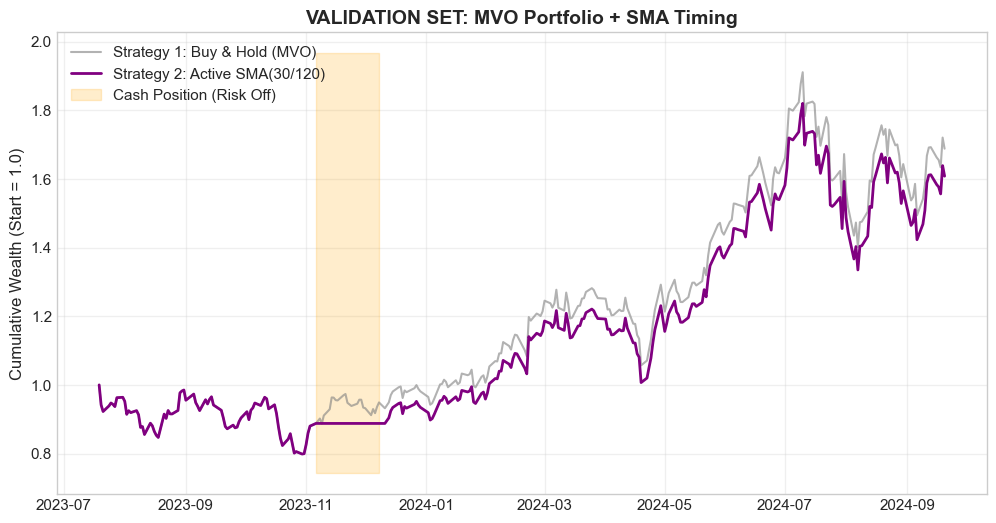


--- PERFORMANCE METRICS (VALIDATION SET - MVO) ---
           Metric Buy & Hold (MVO) SMA Strategy (MVO)
     Total Return           68.85%             60.83%
Annualized Return           56.15%             49.82%
       Volatility           42.43%             41.77%
     Sharpe Ratio             1.32               1.19
     Max Drawdown          -26.66%            -26.66%

[Validation Insight]: The SMA Strategy improved Max Drawdown by +0.00% compared to the passive MVO portfolio.


In [55]:
print("\n========================================================")
print("   PERFORMANCE EVALUATION: MVO PORTFOLIO (VALIDATION SET)")
print("========================================================")

full_data = pd.concat([train_data, valid_data, test_data]).drop_duplicates().sort_index()
returns = full_data.pct_change().dropna()

# 2.1. Construct Portfolio NAV (Buy & Hold)
w_arr = np.array([final_weights_mvo.get(col, 0) for col in full_data.columns])
port_ret = returns.dot(w_arr)
full_bh_nav = (1 + port_ret).cumprod()
full_bh_nav = full_bh_nav / full_bh_nav.iloc[0]

full_sma_s = full_bh_nav.rolling(final_mvo_s).mean()
full_sma_l = full_bh_nav.rolling(final_mvo_l).mean()
full_pos = np.where(full_sma_s > full_sma_l, 1, 0)

strat_ret_series = pd.Series(full_pos).shift(1).fillna(0).values * port_ret.values
full_strat_nav = (1 + strat_ret_series).cumprod()
full_strat_nav = full_strat_nav / full_strat_nav[0]

valid_idx = valid_data.index.intersection(port_ret.index)
valid_bh = full_bh_nav.loc[valid_idx]
valid_bh = valid_bh / valid_bh.iloc[0] 
valid_strat = pd.Series(full_strat_nav, index=port_ret.index).loc[valid_idx]
valid_strat = valid_strat / valid_strat.iloc[0]

valid_pos = pd.Series(full_pos, index=port_ret.index).loc[valid_idx]

plt.figure(figsize=(12, 6))
plt.plot(valid_bh.index, valid_bh, label='Strategy 1: Buy & Hold (MVO)', 
         color='grey', alpha=0.6, linewidth=1.5)
plt.plot(valid_strat.index, valid_strat, label=f'Strategy 2: Active SMA({final_mvo_s}/{final_l})', 
         color='purple', linewidth=2) # Using Purple for MVO
y_min, y_max = plt.ylim()
plt.fill_between(valid_idx, y_min, y_max, where=(valid_pos == 0),
                 color='orange', alpha=0.2, label='Cash Position (Risk Off)')

plt.title('VALIDATION SET: MVO Portfolio + SMA Timing', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Wealth (Start = 1.0)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

def calculate_metrics(series_nav, series_ret):
    total_ret = series_nav.iloc[-1] - 1
    days = (series_nav.index[-1] - series_nav.index[0]).days
    ann_ret = (series_nav.iloc[-1]) ** (365/days) - 1 if days > 0 else 0
    vol = series_ret.std() * np.sqrt(252)
    sharpe = ann_ret / vol if vol != 0 else 0
    peak = series_nav.cummax()
    drawdown = (series_nav - peak) / peak
    max_dd = drawdown.min()
    return total_ret, ann_ret, vol, sharpe, max_dd

# Metrics for Buy & Hold
v_bh_ret = valid_bh.pct_change().dropna()
m_bh = calculate_metrics(valid_bh, v_bh_ret)
# Metrics for Strategy
v_st_ret = valid_strat.pct_change().dropna()
m_st = calculate_metrics(valid_strat, v_st_ret)
# Create Comparison Table
metrics_data = {
    "Metric": ["Total Return", "Annualized Return", "Volatility", "Sharpe Ratio", "Max Drawdown"],
    "Buy & Hold (MVO)": [f"{m_bh[0]:.2%}", f"{m_bh[1]:.2%}", f"{m_bh[2]:.2%}", f"{m_bh[3]:.2f}", f"{m_bh[4]:.2%}"],
    "SMA Strategy (MVO)": [f"{m_st[0]:.2%}", f"{m_st[1]:.2%}", f"{m_st[2]:.2%}", f"{m_st[3]:.2f}", f"{m_st[4]:.2%}"]
}

df_metrics = pd.DataFrame(metrics_data)
print("\n--- PERFORMANCE METRICS (VALIDATION SET - MVO) ---")
print(df_metrics.to_string(index=False))

# Quick Insight
dd_improvement = m_st[4] - m_bh[4]
print(f"\n[Validation Insight]: The SMA Strategy improved Max Drawdown by {dd_improvement:+.2%} compared to the passive MVO portfolio.")

### 3.6: FINAL TEST: Out-of-sample performance on test set


   PART 6: FINAL TEST (OUT-OF-SAMPLE EVALUATION)
--> SELECTED STRATEGY: MVO Max Sharpe
--> SMA PARAMETERS: Short=30, Long=120
--> PORTFOLIO WEIGHTS: OrderedDict({'AAPL': 0.0, 'GOOGL': 0.0, 'MSFT': 0.0, 'NVDA': 0.60871, 'TSLA': 0.39129})


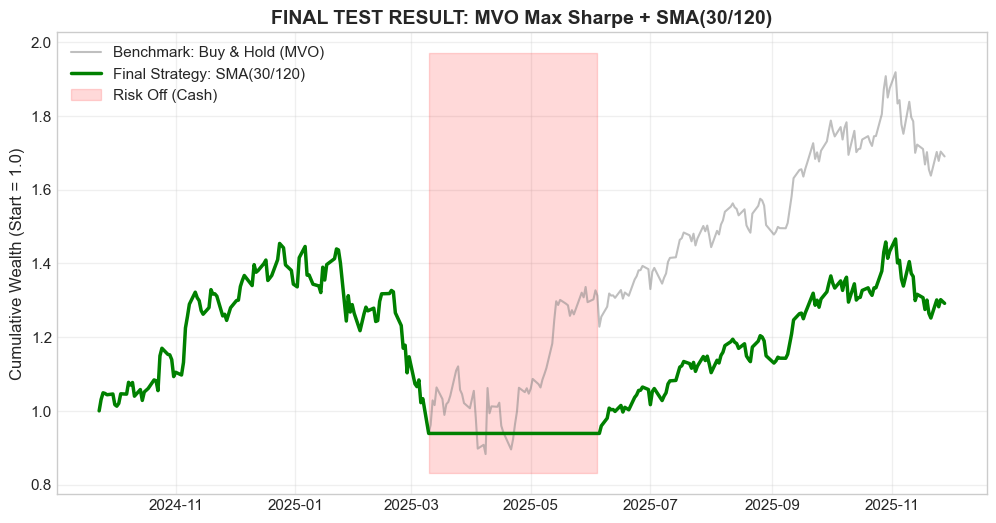


--- FINAL PERFORMANCE CARD (TEST SET) ---
       Metric Buy & Hold Active Strategy
 Total Return     68.98%          29.15%
CAGR (Yearly)     55.94%          24.19%
   Volatility     47.53%          35.97%
 Sharpe Ratio       1.18            0.67
 Max Drawdown    -39.28%         -35.43%

   ACTIONABLE INSIGHT (2025-11-28)
🚀 SIGNAL: [BUY / HOLD]
👉 Action: Allocate capital to the MVO Max Sharpe portfolio:
   - NVDA: 60.87%
   - TSLA: 39.13%


In [ ]:
print("\n========================================================")
print("   FINAL TEST (OUT-OF-SAMPLE EVALUATION)")
print("========================================================")

# 1. STRATEGY SELECTION
SELECTED_STRATEGY = 'MVO'  # Options: 'MVO' or 'EVaR'

try:
    if SELECTED_STRATEGY == 'MVO':
        STRATEGY_NAME = "MVO Max Sharpe"
   
        final_weights = final_weights_mvo
        if not isinstance(final_weights, dict): final_weights = dict(final_weights)
        
        FINAL_S = final_mvo_s
        FINAL_L = final_mvo_l

    elif SELECTED_STRATEGY == 'EVaR':
        STRATEGY_NAME = "EVaR Max Sharpe"
        
        final_weights = final_weights_evar
        if not isinstance(final_weights, dict): final_weights = dict(final_weights)
        
        FINAL_S = final_evar_s
        FINAL_L = final_evar_l
        
    else:
        raise ValueError("Invalid selection. Please choose 'MVO' or 'EVaR'.")

except NameError as e:
    print(f"Error: Missing variables. {e}")
    print("Ensure you have defined 'final_weights_X', 'final_X_s', and 'final_X_l' variables.")
    # Default fallback to prevent crash
    final_weights = {} 
    FINAL_S, FINAL_L = 30, 120

print(f"--> SELECTED STRATEGY: {STRATEGY_NAME}")
print(f"--> SMA PARAMETERS: Short={FINAL_S}, Long={FINAL_L}")
print(f"--> PORTFOLIO WEIGHTS: {final_weights}")

# 2. NAV CALCULATION (FULL HISTORY)
full_data = pd.concat([train_data, valid_data, test_data]).drop_duplicates().sort_index()
returns = full_data.pct_change().dropna()

# 2.1. Calculate Buy & Hold NAV (Benchmark)
w_arr = np.array([final_weights.get(col, 0) for col in full_data.columns])
port_ret = returns.dot(w_arr)
full_bh_nav = (1 + port_ret).cumprod()
full_bh_nav = full_bh_nav / full_bh_nav.iloc[0]

# 2.2. Calculate Active Strategy NAV
# Use the dynamic FINAL_S and FINAL_L
full_sma_s = full_bh_nav.rolling(FINAL_S).mean()
full_sma_l = full_bh_nav.rolling(FINAL_L).mean()

# Signal: 1 = Buy/Hold, 0 = Sell/Cash
full_pos = np.where(full_sma_s > full_sma_l, 1, 0) 

# Strategy Return
strat_ret_series = pd.Series(full_pos).shift(1).fillna(0).values * port_ret.values
full_strat_nav = (1 + strat_ret_series).cumprod()
full_strat_nav = full_strat_nav / full_strat_nav[0]

# =======================================================
# 3. SLICING THE TEST SET (OUT-OF-SAMPLE)
# =======================================================
test_idx = test_data.index.intersection(port_ret.index)

# Benchmark Test NAV
test_bh = full_bh_nav.loc[test_idx]
test_bh = test_bh / test_bh.iloc[0]

# Strategy Test NAV
test_strat = pd.Series(full_strat_nav, index=port_ret.index).loc[test_idx]
test_strat = test_strat / test_strat.iloc[0]

# Signals for Chart
test_pos = pd.Series(full_pos, index=port_ret.index).loc[test_idx]

# =======================================================
# 4. FINAL PERFORMANCE CHART
# =======================================================
plt.figure(figsize=(12, 6))

# Plot Benchmark
plt.plot(test_bh.index, test_bh, label=f'Benchmark: Buy & Hold ({SELECTED_STRATEGY})', 
         color='grey', alpha=0.5, linewidth=1.5)

# Plot Active Strategy
plt.plot(test_strat.index, test_strat, label=f'Final Strategy: SMA({FINAL_S}/{FINAL_L})', 
         color='green', linewidth=2.5) 

# Highlight Cash Positions
y_min, y_max = plt.ylim()
plt.fill_between(test_idx, y_min, y_max, where=(test_pos == 0),
                 color='red', alpha=0.15, label='Risk Off (Cash)')

plt.title(f'FINAL TEST RESULT: {STRATEGY_NAME} + SMA({FINAL_S}/{FINAL_L})', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Wealth (Start = 1.0)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# =======================================================
# 5. METRICS & RECOMMENDATION
# =======================================================
def get_metrics(series_nav):
    ret = series_nav.pct_change().dropna()
    total = series_nav.iloc[-1] - 1
    days = (series_nav.index[-1] - series_nav.index[0]).days
    ann = (series_nav.iloc[-1])**(365/days) - 1 if days > 0 else 0
    vol = ret.std() * np.sqrt(252)
    sharpe = ann / vol if vol != 0 else 0
    dd = (series_nav - series_nav.cummax()) / series_nav.cummax()
    return total, ann, vol, sharpe, dd.min()

m_bh = get_metrics(test_bh)
m_st = get_metrics(test_strat)

# Summary DataFrame
res_df = pd.DataFrame({
    "Metric": ["Total Return", "CAGR (Yearly)", "Volatility", "Sharpe Ratio", "Max Drawdown"],
    "Buy & Hold": [f"{m_bh[0]:.2%}", f"{m_bh[1]:.2%}", f"{m_bh[2]:.2%}", f"{m_bh[3]:.2f}", f"{m_bh[4]:.2%}"],
    "Active Strategy": [f"{m_st[0]:.2%}", f"{m_st[1]:.2%}", f"{m_st[2]:.2%}", f"{m_st[3]:.2f}", f"{m_st[4]:.2%}"]
})

print("\n--- FINAL PERFORMANCE CARD (TEST SET) ---")
print(res_df.to_string(index=False))

# --- ACTIONABLE RECOMMENDATION ---
last_signal = full_pos[-1]
last_date = full_data.index[-1].date()

print("\n" + "="*40)
print(f"   ACTIONABLE INSIGHT ({last_date})")
print("="*40)
if last_signal == 1:
    print(f"🚀 SIGNAL: [BUY / HOLD]")
    print(f"👉 Action: Allocate capital to the {STRATEGY_NAME} portfolio:")
    for k, v in final_weights.items():
        if v > 0.001: print(f"   - {k}: {v:.2%}")
else:
    print(f"🛡️ SIGNAL: [SELL / CASH]")
    print(f"👉 Action: Market Risk Detected. Sell equity portfolio, hold 100% Cash/T-Bills.")
print("="*40)

# SUMMARY

In this lecture, we have built a quantitative financial analysis workflow:

1.  **Part 1 (Foundations):** Built a detailed lecture on core time series concepts (Resampling, Returns, SMA, Volatility, Correlation).

2.  **Part 2 (Optimization & Testing):** 
    * Established an objective **Train/Test** workflow (2 years Train, 1 month Test).
    * Used sequential code (no functions) to **Train** optimization models (n-Sharpe, n-Vol, k-Sharpe, k-Vol) *only on the Train Set*.
    * **Tested** 5 strategies (including Benchmark) objectively *only on the Test Set*.
    * Compared the results using both charts and a metrics table (Sharpe, APY, Max Drawdown) to find the best "out-of-sample" strategy.

# REFERENCES

1.  **Hilpisch, Yves (2018). "Python for Finance: Mastering Data-Driven Finance". O'Reilly Media.**
    *(Main content for Part 1 and Backtesting theory)*

2.  **McKinney, Wes (2022). "Python for Data Analysis: Data Wrangling with pandas, NumPy, and Jupyter". O'Reilly Media.**
    *(Supplementary content for Part 1 - Time Series Analysis)*

3.  **PyPortfolioOpt Documentation:**
    *https://pyportfolioopt.readthedocs.io/*
    *(Main content for Part 2 - Portfolio Optimization)*

4.  **(Advanced) López de Prado, Marcos (2018). "Advances in Financial Machine Learning". Wiley.**
    *(Reference for robust backtesting theory)*